In [71]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot, u_darrays as uda, u_met
import pandas as pd
import metpy
from metpy import calc
from metpy.plots import SkewT
from metpy.units import pandas_dataframe_to_unit_arrays, units

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (30., 30.)
#%matplotlib inline

In [70]:
cd ..

/home/ck/pythonWorkspace


In [72]:
pdf = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA.p', 'rb'))

In [73]:
pdf_all = pdf.where((pdf.clat>=5.1) & (pdf.clat<=8.5) & (pdf.clon>=-10) & (pdf.clon<=12) &
                    (pdf.year >=2000) & (pdf.year <=2014)) # 2000-2014!
pdf_all = pdf_all.dropna()

In [74]:
np.unique(pdf_all.year)

array([2000., 2001., 2002., 2003., 2004., 2005., 2006., 2007., 2008.,
       2009., 2010., 2011., 2012., 2013., 2014.])

In [75]:
pdf_march = pdf.where((pdf.clat>=5.1) & (pdf.clat<=8.5) & (pdf.clon>=-10) & (pdf.clon<=12) &
(pdf.month == 3) & (pdf.year >=2000) & (pdf.year <=2012))
pdf_march = pdf_march.dropna()

In [76]:
pdf_oct = pdf.where((pdf.clat>=5.1) & (pdf.clat<=8.5) & (pdf.clon>=-10) & (pdf.clon<=12) &
(pdf.month == 10) & (pdf.year >=2000) & (pdf.year <=2012))
pdf_oct = pdf_oct.dropna()

In [77]:
era_pl = xr.open_mfdataset('/home/ck/DIR/mymachine/ERA5/hourly/pressure_levels/ERA5_2015*.nc')


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


In [78]:
era_srfc = xr.open_mfdataset('/home/ck/DIR/mymachine/ERA5/hourly/surface/*.nc')

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


KeyboardInterrupt: 

In [ ]:
era_pl = uda.flip_lat(era_pl)
era_srfc = uda.flip_lat(era_srfc)

In [ ]:
np.unique(era_srfc['time.hour'])

In [ ]:
# era_out = get_ERA5(era_pl, era_srfc, pdf_all)
# pkl.dump(era_out,open(cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_2006-2014_small.p', 'wb'))

In [ ]:
# era_clim_out = get_ERA5_clim(era_pl_mean, era_srfc_mean, pdf_march)
# pkl.dump(era_clim_out,open(cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_march_clim.p', 'wb'))

In [79]:
era_storm = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_5-8N_2000-2014_18UTC_front.p', 'rb'))
era_clim = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_5-8N_2000-2014_18UTC_front_CLIM.p', 'rb'))

In [80]:
level = era_storm.pop('level')
level = era_clim.pop('level')

In [81]:
era_storm['q_col'][0]*1000

array([ 0.07114187,  0.2702782 ,  0.61654764,  0.9907223 ,  1.3845563 ,
        1.8494203 ,  2.7839048 ,  4.72422   ,  4.7264395 ,  4.8631086 ,
        7.182354  ,  8.968244  , 11.5173855 , 12.490555  , 13.432014  ,
       14.036084  , 14.645228  , 15.61491   , 15.804216  ], dtype=float32)

In [82]:
level = level[0:19]

In [83]:
level

[200,
 250,
 300,
 350,
 400,
 450,
 500,
 550,
 600,
 650,
 700,
 750,
 825,
 850,
 875,
 900,
 925,
 950,
 975]

In [84]:
era_storm['t_col'][0]

array([218.4919 , 231.42618, 240.7842 , 249.50555, 256.76318, 262.5221 ,
       267.24527, 270.9906 , 274.2653 , 278.37466, 281.81995, 284.6301 ,
       288.06168, 289.70816, 291.03937, 292.59598, 294.17392, 295.7549 ,
       297.87357], dtype=float32)

In [85]:
era_pl.level

<xarray.DataArray 'level' (level: 19)>
array([200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 825, 850,
       875, 900, 925, 950, 975], dtype=int32)
Coordinates:
  * level    (level) int32 200 250 300 350 400 450 ... 850 875 900 925 950 975
Attributes:
    units:      millibars
    long_name:  pressure_level

In [86]:
era_storm['area'] = np.array(era_storm['area'])*7.7**2
era_clim['area'] = np.array(era_clim['area'])*7.7**2

In [223]:
def indic(era_dic):
    s1 = {}
    s2 = {}
    march = {}
    octt = {}

    full = {}
    
    
    for k in era_dic.keys():
        print(k)
    #     if k == 'dates':
    #         continue
        alls = []
        first = []
        second = []
        o = []
        m = []
        theta_all = []
        theta_s1 = []
        theta_s2 = []
        for ids, ise in enumerate(era_dic[k]):
            
            if (era_dic['area'])[ids] < 5000:
                continue
            
            if k == 't_col':
              
                #th = u_met.theta_e(np.array(level), np.array(era_dic['t_col'][ids])-273.15, np.array(era_dic['q_col'][ids]))
               
                th = u_met.theta(np.array(level), np.array(era_dic['t_col'][ids])-273.15)
                

            diff = np.array(ise)
            if ((era_dic['dates'][ids].month <=6) & (era_dic['dates'][ids].month >=2)) | \
            ((era_dic['dates'][ids].month >=9) & (era_dic['dates'][ids].month <=11)):
                alls.append(diff)
                if k == 't_col':
                    theta_all.append(th)

            if ((era_dic['dates'][ids].month <=5) & (era_dic['dates'][ids].month >=3)):
                first.append(diff)
                if k == 't_col':
                    theta_s1.append(th)

            if ((era_dic['dates'][ids].month >=9) & (era_dic['dates'][ids].month <=11)):
                second.append(diff)
                if k == 't_col':
                    theta_s2.append(th)

            if era_dic['dates'][ids].month == 3:
                m.append(diff)
            if era_dic['dates'][ids].month == 10:
                o.append(diff)
                
        s1[k] = np.array(first)          
        s2[k] = np.array(second)
        march[k] = np.array(m)
        octt[k] = np.array(o)
        full[k] = np.array(alls)
        if k == 't_col':
            full['theta'] = np.array(theta_all)
            s1['theta'] = np.array(theta_s1)
            s2['theta'] = np.array(theta_s2)
    return s1, s2, march, octt, full

In [224]:
s1, s2, era_march, era_oct, full = indic(era_storm)

q925_s
u650_s
q925
divMoist_s
q_col_s
q_col
q700_s
t10
r_col
tmean
t2_s
lat
t_col
area
area70
u650
t_col_s
tcwv
dates
slp_s
r_col_s
lon
v_col
CAPE_s
d925_s
v_col_s
u925_s
u_col_s
q700
t2
CAPE
u_col
slp
tcwv_s
u925
divMoist
d_col
d_col_s
d925
tmin


In [225]:
s1_clim, s2_clim, clim_march, clim_oct, clim_full = indic(era_clim)

q925_s
u650_s
q925
divMoist_s
q_col_s
q_col
q700_s
t10
r_col
tmean
t2_s
lat
t_col
area
area70
u650
t_col_s
tcwv
dates
slp_s
r_col_s
lon
v_col
CAPE_s
d925_s
v_col_s
u925_s
u_col_s
q700
t2
CAPE
u_col
slp
tcwv_s
u925
divMoist
d_col
d_col_s
d925
tmin


In [226]:
era_oct = s2
era_march = s1
clim_oct = s2_clim
clim_march = s1_clim

In [227]:
print(np.array(era_oct['CAPE']).mean())
print(np.array(clim_oct['CAPE']).mean())

960.8955746134433
847.2043638506336


In [228]:
print(np.array(era_march['CAPE']).mean())
print(np.array(clim_march['CAPE']).mean())

1199.132759965733
1098.7346309356624


In [229]:
perc_mar = np.percentile(era_march['tmin'],[10,90])
perc_oct = np.percentile(era_oct['tmin'],[10,90])

In [252]:
ostrong = np.where(era_oct['tmin'] < perc_oct[0])[0]
oweak = np.where(era_oct['tmin'] > perc_oct[1])[0]
mstrong = np.where(era_march['tmin'] < perc_mar[0])[0]
mweak = np.where(era_march['tmin'] > perc_mar[1])[0]
oct_strong = {}
oct_weak = {}
mar_strong = {}
mar_weak = {}

for v in era_march.keys():
    print(v)
    oct_strong[v] = np.array(era_oct[v])[ostrong]
    oct_weak[v] = np.array(era_oct[v])[oweak]
    mar_strong[v] = np.array(era_march[v])[mstrong]
    mar_weak[v] = np.array(era_march[v])[mweak]    

q925_s
u650_s
q925
divMoist_s
q_col_s
q_col
q700_s
t10
r_col
tmean
t2_s
lat
t_col
theta
area
area70
u650
t_col_s
tcwv
dates
slp_s
r_col_s
lon
v_col
CAPE_s
d925_s
v_col_s
u925_s
u_col_s
q700
t2
CAPE
u_col
slp
tcwv_s
u925
divMoist
d_col
d_col_s
d925
tmin


In [263]:
p = units.Quantity(level, 'hPa')
tmar = units.Quantity(np.mean(mar_weak['t_col'], axis=0), 'K')
toct = units.Quantity(np.mean(oct_strong['t_col'], axis=0), 'K')
umar = units.Quantity(np.mean(mar_weak['u_col'], axis=0), 'K')
uoct = units.Quantity(np.mean(oct_strong['u_col'], axis=0), 'K')
vmar = units.Quantity(np.mean(mar_weak['v_col'], axis=0), 'K')
voct = units.Quantity(np.mean(oct_strong['v_col'], axis=0), 'K')
qmar = units.Quantity(np.mean(mar_weak['q_col'], axis=0), 'kg/kg')
qoct = units.Quantity(np.mean(oct_strong['q_col'], axis=0), 'kg/kg')

In [264]:
# p = units.Quantity(level, 'hPa')
# tmar = units.Quantity(np.mean(clim_march['t_col'], axis=0).squeeze(), 'K')
# toct = units.Quantity(np.mean(clim_oct['t_col'], axis=0).squeeze(), 'K')
# umar = units.Quantity(np.mean(clim_march['u_col'], axis=0).squeeze(), 'K')
# uoct = units.Quantity(np.mean(clim_oct['u_col'], axis=0).squeeze(), 'K')
# vmar = units.Quantity(np.mean(clim_march['v_col'], axis=0).squeeze(), 'K')
# voct = units.Quantity(np.mean(clim_oct['v_col'], axis=0).squeeze(), 'K')
# qmar = units.Quantity(np.mean(clim_march['q_col'], axis=0).squeeze(), 'kg/kg')
# qoct = units.Quantity(np.mean(clim_oct['q_col'], axis=0).squeeze(), 'kg/kg')

In [265]:
dpmar = calc.dewpoint_from_specific_humidity(qmar, tmar, p)
dpoct = calc.dewpoint_from_specific_humidity(qoct, toct, p)

In [266]:
pp = calc.parcel_profile(p[::-1],tmar[18], dpmar[18])

In [270]:
print(np.mean(mar_weak['CAPE']))
print(np.mean(mar_strong['CAPE']))

1081.0938328677773
1307.632619503804


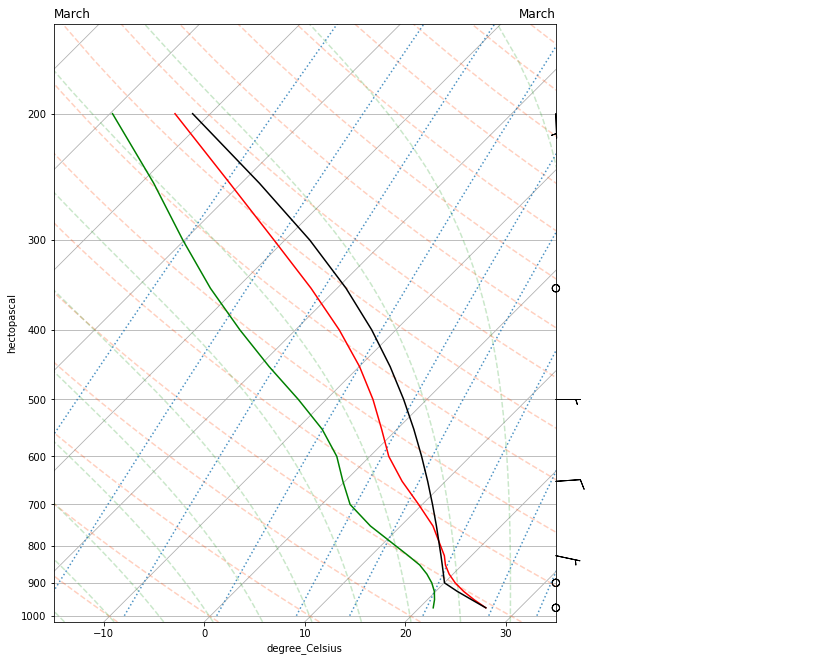

In [268]:
pp = calc.parcel_profile(p[::-1],tmar[18], dpmar[18])
ppo = calc.parcel_profile(p[::-1],toct[18], dpoct[18])

# Change default to be better for skew-T
fig = plt.figure(figsize=(9, 11))

# Initiate the skew-T plot type from MetPy class loaded earlier
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, tmar, 'r')
skew.plot(p, dpmar, 'g')
skew.plot(p,pp[::-1],'k')

# skew.plot(p, toct, 'orange')
# skew.plot(p, dpoct, 'b')
# skew.plot(p,ppo[::-1],'purple')

skew.plot_barbs(p[::3], umar[::3], vmar[::3], y_clip_radius=0.03)

# Set some appropriate axes limits for x and y
skew.ax.set_xlim(-15, 35)
skew.ax.set_ylim(1020, 150)

# Add the relevant special lines to plot throughout the figure
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K,
                       alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K,
                         alpha=0.25, color='tab:green')
skew.plot_mixing_lines(p=np.arange(1000, 99, -20) * units.hPa,
                       linestyle='dotted', color='tab:blue')

# Add some descriptive titles
plt.title('March', loc='left')
plt.title('March', loc='right')

plt.show()

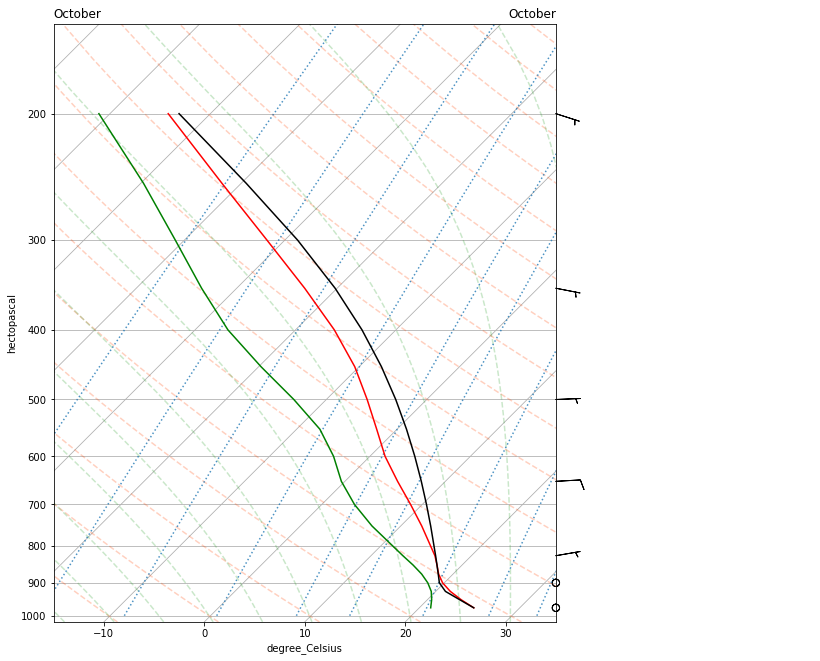

In [237]:
pp = calc.parcel_profile(p[::-1],toct[18], dpoct[18])

# Change default to be better for skew-T
fig = plt.figure(figsize=(9, 11))

# Initiate the skew-T plot type from MetPy class loaded earlier
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, toct, 'r')
skew.plot(p, dpoct, 'g')
skew.plot(p,pp[::-1],'k')
skew.plot_barbs(p[::3], uoct[::3], voct[::3], y_clip_radius=0.03)

# Set some appropriate axes limits for x and y
skew.ax.set_xlim(-15, 35)
skew.ax.set_ylim(1020, 150)

# Add the relevant special lines to plot throughout the figure
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K,
                       alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K,
                         alpha=0.25, color='tab:green')
skew.plot_mixing_lines(p=np.arange(1000, 99, -20) * units.hPa,
                       linestyle='dotted', color='tab:blue')

# Add some descriptive titles
plt.title('October', loc='left')
plt.title('October', loc='right')

plt.show()

In [238]:
era_march['q_col']

array([[4.7032721e-05, 1.0071229e-04, 1.6493071e-04, ..., 1.5442282e-02,
        1.7223926e-02, 1.7763358e-02],
       [4.0116720e-05, 6.9426373e-05, 2.5351904e-04, ..., 1.7138960e-02,
        1.7315807e-02, 1.7479151e-02],
       [4.0775165e-05, 7.8648329e-05, 1.7513987e-04, ..., 1.7414603e-02,
        1.8091695e-02, 1.8281715e-02],
       ...,
       [3.3846125e-05, 4.6616420e-05, 1.5015900e-04, ..., 1.5491998e-02,
        1.6394541e-02, 1.6495321e-02],
       [7.6988712e-05, 2.9166602e-04, 5.9746113e-04, ..., 1.5160318e-02,
        1.5998665e-02, 1.6684804e-02],
       [6.9741160e-05, 1.6499963e-04, 3.1893235e-04, ..., 1.6185040e-02,
        1.6916737e-02, 1.7085858e-02]], dtype=float32)

In [239]:
era_oct['theta'][0]

array([73.72262787, 71.39371144, 68.07015366, 64.98580669, 60.85406535,
       57.77509483, 53.71953558, 48.49202944, 44.39993035, 41.58462602,
       39.20386812, 36.47505901, 32.36986313, 30.89493681, 29.16972201,
       27.44908081, 26.10499193, 24.92168597, 24.60737318])

In [240]:
ostrong = np.where(era_oct['tmin'] < perc_oct[0])[0]
oweak = np.where(era_oct['tmin'] > perc_oct[1])[0]
mstrong = np.where(era_march['tmin'] < perc_mar[0])[0]
mweak = np.where(era_march['tmin'] > perc_mar[1])[0]
oct_strong = {}
oct_weak = {}
mar_strong = {}
mar_weak = {}

for v in era_march.keys():
    print(v)
    oct_strong[v] = np.array(era_oct[v])[ostrong]
    oct_weak[v] = np.array(era_oct[v])[oweak]
    mar_strong[v] = np.array(era_march[v])[mstrong]
    mar_weak[v] = np.array(era_march[v])[mweak]    

q925_s
u650_s
q925
divMoist_s
q_col_s
q_col
q700_s
t10
r_col
tmean
t2_s
lat
t_col
theta
area
area70
u650
t_col_s
tcwv
dates
slp_s
r_col_s
lon
v_col
CAPE_s
d925_s
v_col_s
u925_s
u_col_s
q700
t2
CAPE
u_col
slp
tcwv_s
u925
divMoist
d_col
d_col_s
d925
tmin


In [241]:
print('MarchQ', mar_strong['q925'].mean()*1000, mar_weak['q925'].mean()*1000)
print('OctQ', oct_strong['q925'].mean()*1000, oct_weak['q925'].mean()*1000)

MarchQ 16.07430422288166 15.806516128966313
OctQ 15.727750981847446 15.245157862444977


In [242]:
print('MarchShear', mar_strong['u650'].mean()-mar_strong['u925'].mean(), mar_weak['u650'].mean()-mar_weak['u925'].mean())
print('OctShear', oct_strong['u650'].mean()-oct_strong['u925'].mean(), oct_weak['u650'].mean()-oct_weak['u925'].mean())

MarchShear -13.800056867476341 -11.23364667464784
OctShear -10.283761331940896 -7.376862583059044


(19,)


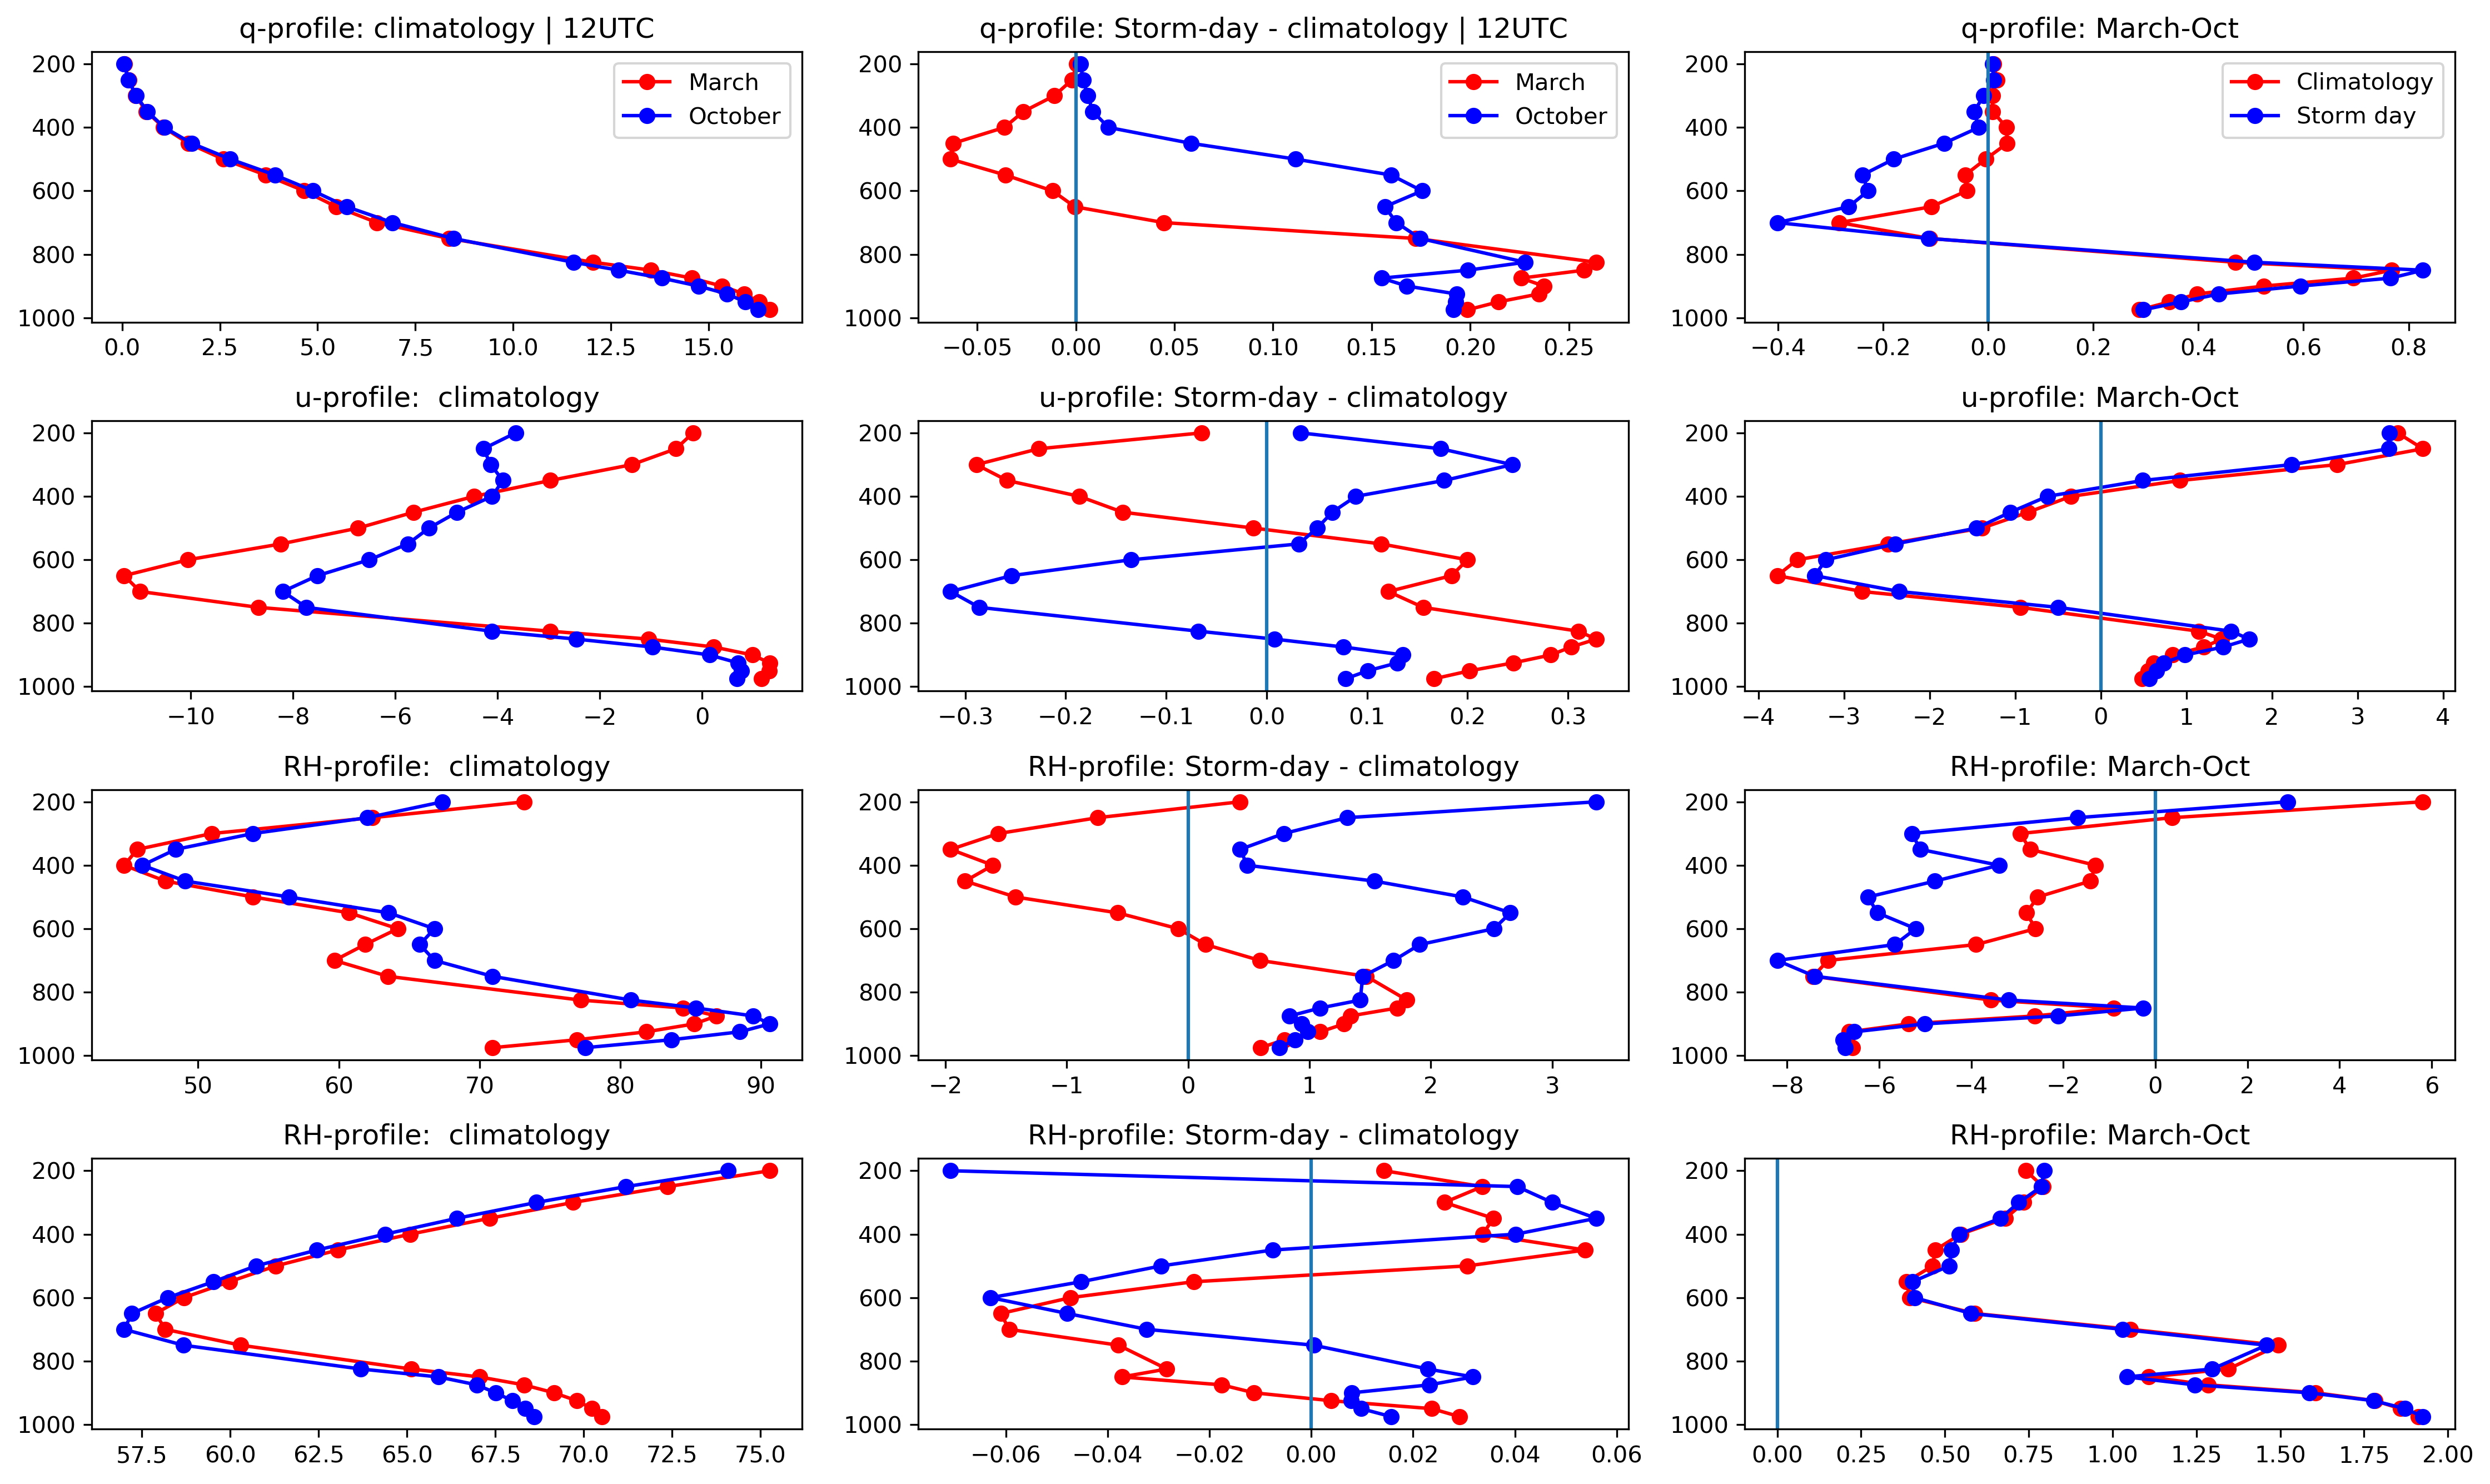

In [243]:
q_march =  np.array(era_march['q_col']).mean(axis=0)*1000 
q_oct =  np.array(era_oct['q_col']).mean(axis=0)*1000 
print(q_march.shape)
f = plt.figure(figsize=(15,9), dpi=300)
f.add_subplot(431)

plt.plot(q_march.squeeze(), level,'ro-', label='March')
plt.plot(q_oct.squeeze(), level,'bo-', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: climatology | 12UTC')
plt.legend()

q_march =  np.array(clim_march['u_col']).mean(axis=0).squeeze()
q_oct =  np.array(clim_oct['u_col']).mean(axis=0).squeeze()
f.add_subplot(434)
plt.plot(q_march, level,'ro-', label='March')
plt.plot(q_oct, level,'bo-', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile:  climatology')

q_march = np.array(era_march['q_col']).mean(axis=0)*1000 - np.array(clim_march['q_col']).mean(axis=0).squeeze()*1000 
q_oct = np.array(era_oct['q_col']).mean(axis=0)*1000 - np.array(clim_oct['q_col']).mean(axis=0).squeeze()*1000 

f.add_subplot(432)
plt.plot(q_march, level,'ro-', label='March')
plt.plot(q_oct, level,'bo-', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: Storm-day - climatology | 12UTC')
plt.legend()

q_march = np.array(era_march['u_col']).mean(axis=0) - np.array(clim_march['u_col']).mean(axis=0).squeeze()
q_oct = np.array(era_oct['u_col']).mean(axis=0) - np.array(clim_oct['u_col']).mean(axis=0).squeeze()
f.add_subplot(435)
plt.plot(q_march, level,'o-r', label='March')
plt.plot(q_oct, level,'bo-', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile: Storm-day - climatology')


q_march = np.array(clim_march['q_col']).mean(axis=0).squeeze()*1000  - np.array(clim_oct['q_col']).mean(axis=0).squeeze()*1000 
q_oct = np.array(era_march['q_col']).mean(axis=0)*1000 - np.array(era_oct['q_col']).mean(axis=0)*1000
f.add_subplot(433)
plt.plot(q_march, level,'ro-', label='Climatology')
plt.plot(q_oct, level,'bo-', label='Storm day')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: March-Oct')
plt.legend()

q_march = np.array(clim_march['u_col']).mean(axis=0).squeeze() - np.array(clim_oct['u_col']).mean(axis=0).squeeze()
q_oct = np.array(era_march['u_col']).mean(axis=0) - np.array(era_oct['u_col']).mean(axis=0)
f.add_subplot(436)
plt.plot(q_march, level,'ro-', label='Climatology')
plt.plot(q_oct, level,'bo-', label='Storm day')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile: March-Oct')

sstr = 'r_col'

q_march =  np.array(clim_march[sstr]).mean(axis=0).squeeze()
q_oct =  np.array(clim_oct[sstr]).mean(axis=0).squeeze()

#q_march = u_met.theta_e()

f.add_subplot(437)
plt.plot(q_march, level,'ro-', label='March')
plt.plot(q_oct, level,'bo-', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile:  climatology')

q_march = np.array(era_march[sstr]).mean(axis=0) - np.array(clim_march[sstr]).mean(axis=0).squeeze()
q_oct = np.array(era_oct[sstr]).mean(axis=0) - np.array(clim_oct[sstr]).mean(axis=0).squeeze()
f.add_subplot(438)
plt.plot(q_march, level,'ro-', label='March')
plt.plot(q_oct, level,'bo-', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile: Storm-day - climatology')

q_march = np.array(clim_march[sstr]).mean(axis=0).squeeze() - np.array(clim_oct[sstr]).mean(axis=0).squeeze()
q_oct = np.array(era_march[sstr]).mean(axis=0) - np.array(era_oct[sstr]).mean(axis=0)
f.add_subplot(439)
plt.plot(q_march, level,'ro-', label='Climatology')
plt.plot(q_oct, level,'bo-', label='Storm day')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile: March-Oct')

################

sstr = 't_col'
strr = 'q_col'

q_march =  u_met.theta_e(np.array(level), np.array(clim_march[sstr]).mean(axis=0).squeeze()-273.15, np.array(clim_march[strr]).mean(axis=0).squeeze())
q_oct =  u_met.theta_e(np.array(level), np.array(clim_oct[sstr]).mean(axis=0).squeeze()-273.15, np.array(clim_march[strr]).mean(axis=0).squeeze())
f.add_subplot(4,3,10)
plt.plot(q_march, level,'ro-', label='March')
plt.plot(q_oct, level,'bo-', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile:  climatology')

q_march = u_met.theta_e(np.array(level),np.array(era_march[sstr]).mean(axis=0)-273.15,  np.array(clim_march[strr]).mean(axis=0).squeeze()) - \
            u_met.theta_e(np.array(level),np.array(clim_march[sstr]).mean(axis=0).squeeze()-273.15, np.array(clim_march[strr]).mean(axis=0).squeeze())
q_oct = u_met.theta_e(np.array(level), np.array(era_oct[sstr]).mean(axis=0)-273.15,  np.array(clim_march[strr]).mean(axis=0).squeeze()) - \
             u_met.theta_e(np.array(level),np.array(clim_oct[sstr]).mean(axis=0).squeeze()-273.15, np.array(clim_march[strr]).mean(axis=0).squeeze())
f.add_subplot(4,3,11)
plt.plot(q_march, level,'ro-', label='March')
plt.plot(q_oct, level,'bo-', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile: Storm-day - climatology')

q_march = np.array(clim_march[sstr]).mean(axis=0).squeeze() - np.array(clim_oct[sstr]).mean(axis=0).squeeze()
q_oct = np.array(era_march[sstr]).mean(axis=0) - np.array(era_oct[sstr]).mean(axis=0)
f.add_subplot(4,3,12)
plt.plot(q_march, level,'ro-', label='Climatology')
plt.plot(q_oct, level,'bo-', label='Storm day')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile: March-Oct')


plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/uRHq_profiles.png')

In [244]:
era_pl.level.values

array([200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 825,
       850, 875, 900, 925, 950, 975], dtype=int32)

(19,)


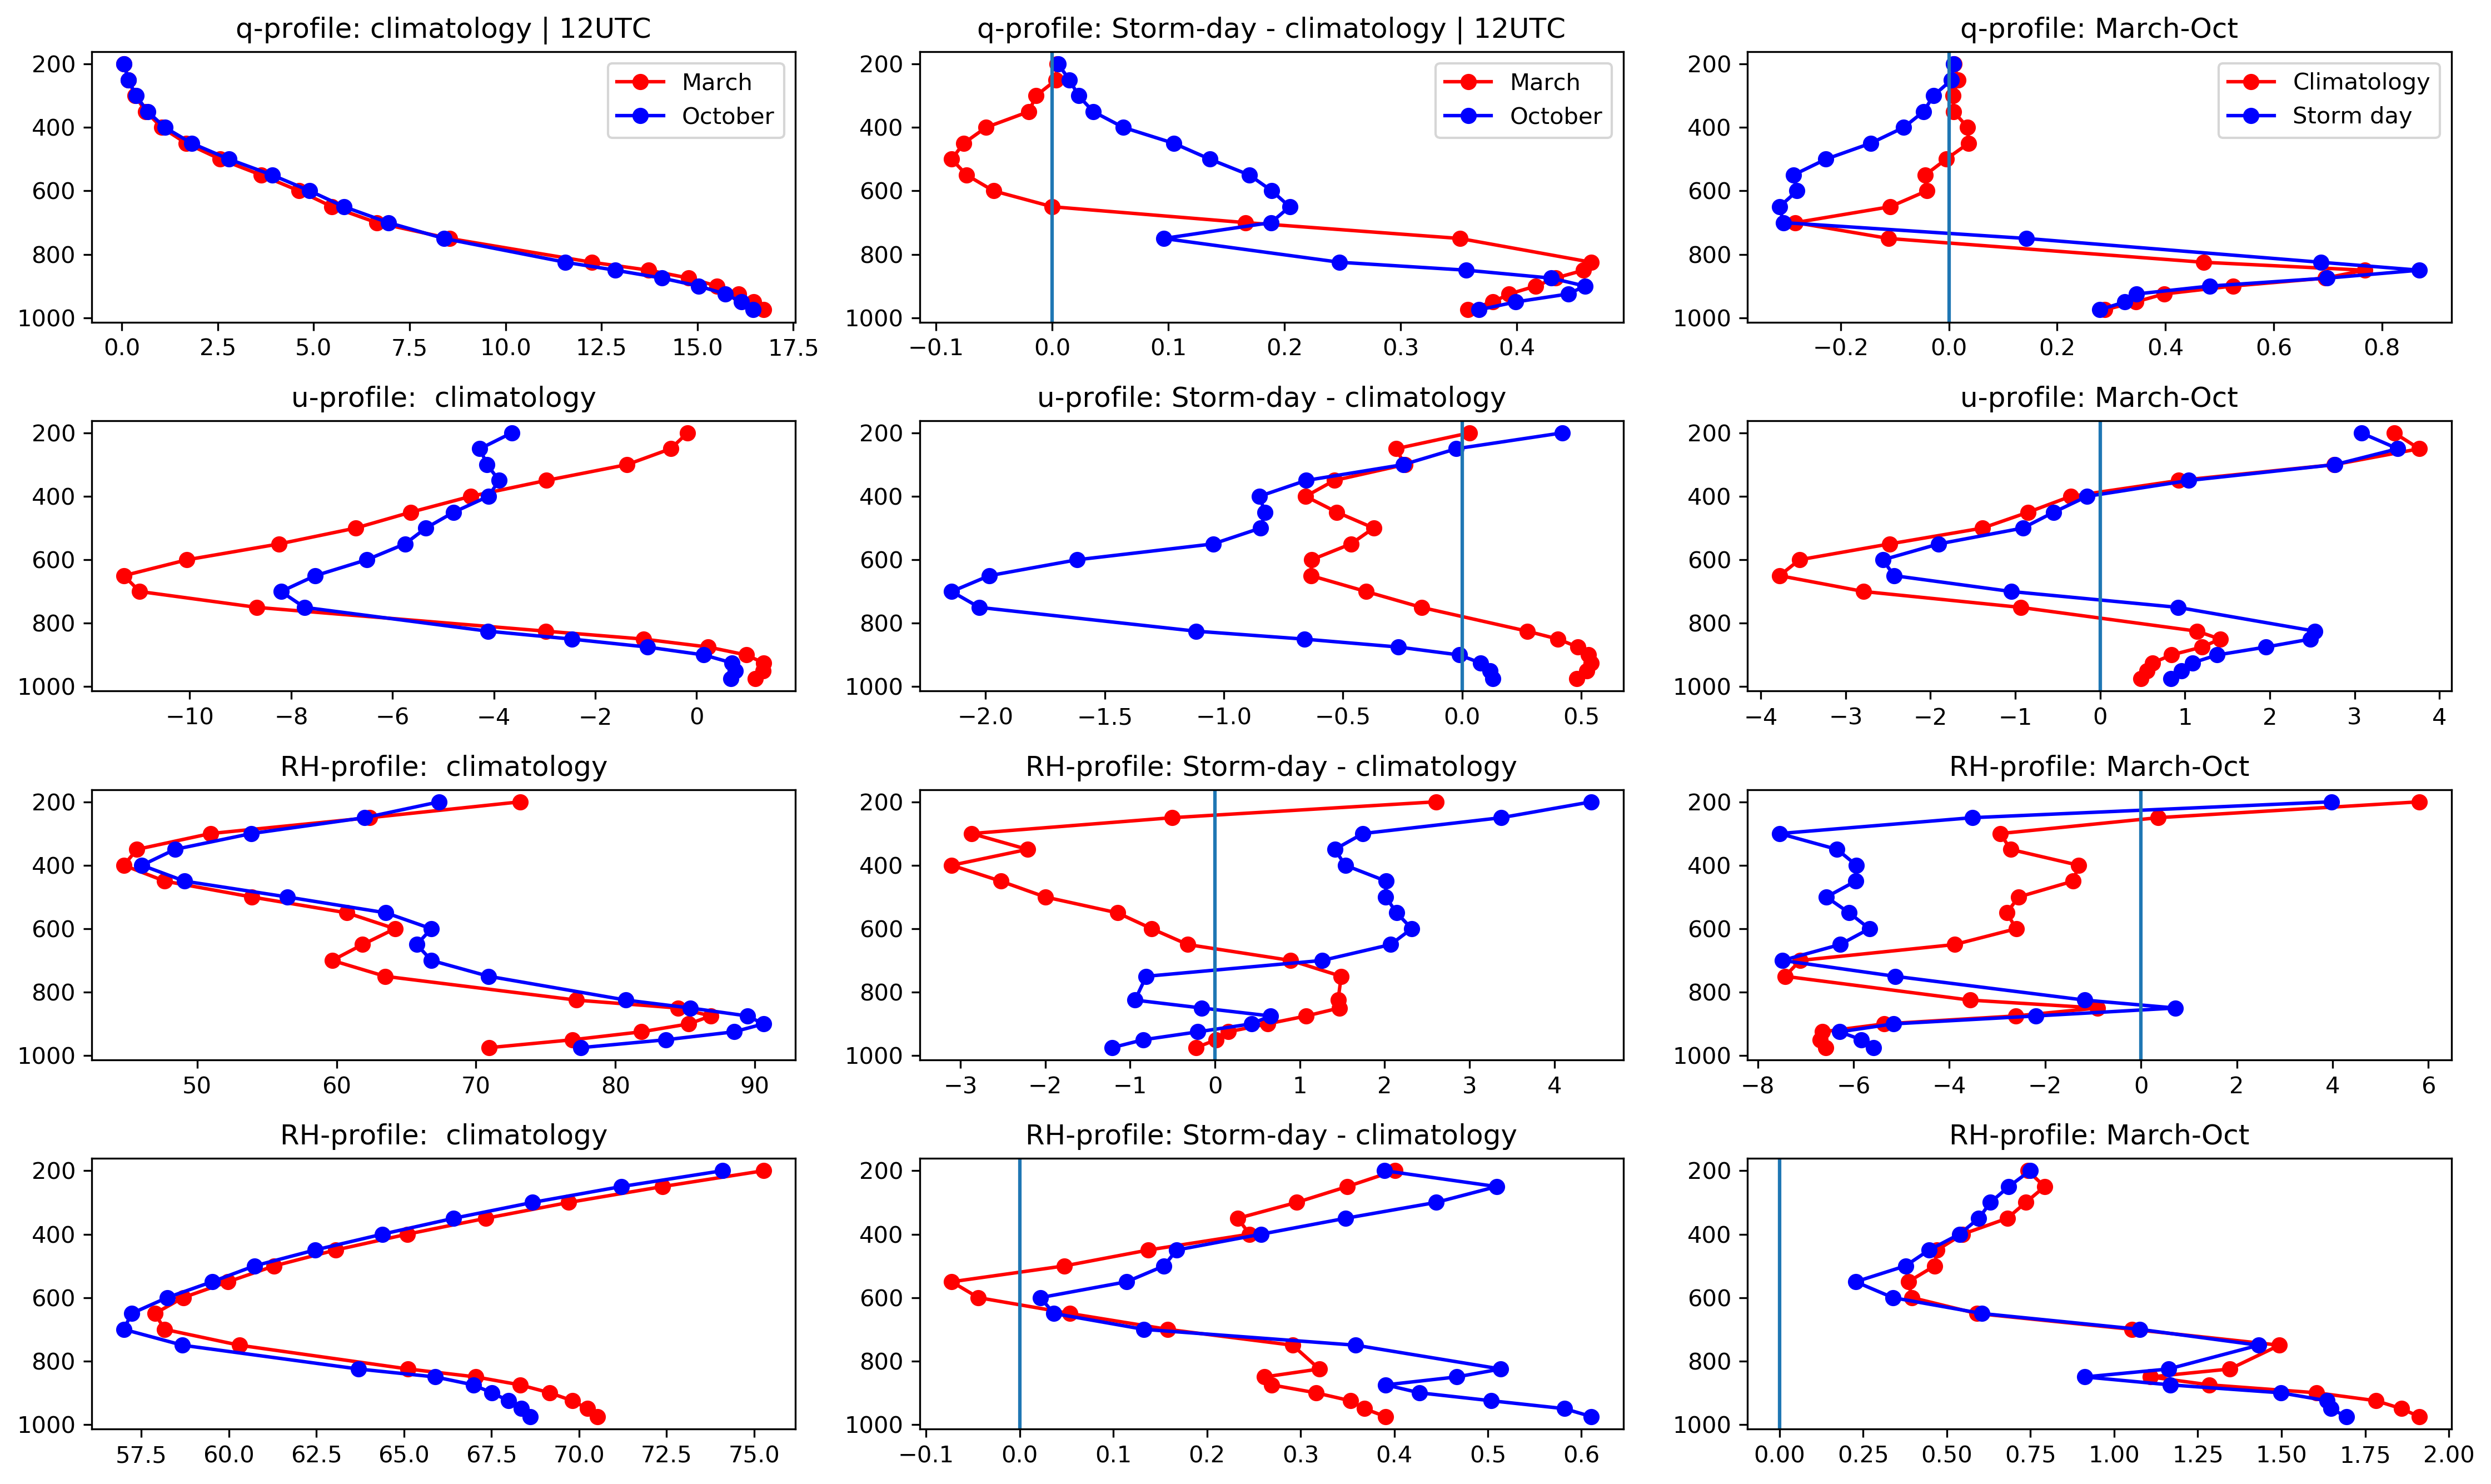

In [245]:
q_march =  np.array(mar_strong['q_col']).mean(axis=0)*1000 
q_oct =  np.array(oct_strong['q_col']).mean(axis=0)*1000 
print(q_march.shape)
f = plt.figure(figsize=(15,9), dpi=300)
f.add_subplot(431)

plt.plot(q_march.squeeze(), level,'ro-', label='March')
plt.plot(q_oct.squeeze(), level,'bo-', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: climatology | 12UTC')
plt.legend()

q_march =  np.array(clim_march['u_col']).mean(axis=0).squeeze()
q_oct =  np.array(clim_oct['u_col']).mean(axis=0).squeeze()
f.add_subplot(434)
plt.plot(q_march, level,'ro-', label='March')
plt.plot(q_oct, level,'bo-', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile:  climatology')

q_march = np.array(mar_strong['q_col']).mean(axis=0)*1000 - np.array(clim_march['q_col']).mean(axis=0).squeeze()*1000 
q_oct = np.array(oct_strong['q_col']).mean(axis=0)*1000 - np.array(clim_oct['q_col']).mean(axis=0).squeeze()*1000 

f.add_subplot(432)
plt.plot(q_march, level,'ro-', label='March')
plt.plot(q_oct, level,'bo-', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: Storm-day - climatology | 12UTC')
plt.legend()

q_march = np.array(mar_strong['u_col']).mean(axis=0) - np.array(clim_march['u_col']).mean(axis=0).squeeze()
q_oct = np.array(oct_strong['u_col']).mean(axis=0) - np.array(clim_oct['u_col']).mean(axis=0).squeeze()
f.add_subplot(435)
plt.plot(q_march, level,'o-r', label='March')
plt.plot(q_oct, level,'bo-', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile: Storm-day - climatology')


q_march = np.array(clim_march['q_col']).mean(axis=0).squeeze()*1000  - np.array(clim_oct['q_col']).mean(axis=0).squeeze()*1000 
q_oct = np.array(mar_strong['q_col']).mean(axis=0)*1000 - np.array(oct_strong['q_col']).mean(axis=0)*1000
f.add_subplot(433)
plt.plot(q_march, level,'ro-', label='Climatology')
plt.plot(q_oct, level,'bo-', label='Storm day')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: March-Oct')
plt.legend()

q_march = np.array(clim_march['u_col']).mean(axis=0).squeeze() - np.array(clim_oct['u_col']).mean(axis=0).squeeze()
q_oct = np.array(mar_strong['u_col']).mean(axis=0) - np.array(oct_strong['u_col']).mean(axis=0)
f.add_subplot(436)
plt.plot(q_march, level,'ro-', label='Climatology')
plt.plot(q_oct, level,'bo-', label='Storm day')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile: March-Oct')

sstr = 'r_col'

q_march =  np.array(clim_march[sstr]).mean(axis=0).squeeze()
q_oct =  np.array(clim_oct[sstr]).mean(axis=0).squeeze()

#q_march = u_met.theta_e()

f.add_subplot(437)
plt.plot(q_march, level,'ro-', label='March')
plt.plot(q_oct, level,'bo-', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile:  climatology')

q_march = np.array(mar_strong[sstr]).mean(axis=0) - np.array(clim_march[sstr]).mean(axis=0).squeeze()
q_oct = np.array(oct_strong[sstr]).mean(axis=0) - np.array(clim_oct[sstr]).mean(axis=0).squeeze()
f.add_subplot(438)
plt.plot(q_march, level,'ro-', label='March')
plt.plot(q_oct, level,'bo-', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile: Storm-day - climatology')

q_march = np.array(clim_march[sstr]).mean(axis=0).squeeze() - np.array(clim_oct[sstr]).mean(axis=0).squeeze()
q_oct = np.array(mar_strong[sstr]).mean(axis=0) - np.array(oct_strong[sstr]).mean(axis=0)
f.add_subplot(439)
plt.plot(q_march, level,'ro-', label='Climatology')
plt.plot(q_oct, level,'bo-', label='Storm day')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile: March-Oct')

################

sstr = 't_col'
strr = 'q_col'

q_march =  u_met.theta_e(np.array(level), np.array(clim_march[sstr]).mean(axis=0).squeeze()-273.15, np.array(clim_march[strr]).mean(axis=0).squeeze())
q_oct =  u_met.theta_e(np.array(level), np.array(clim_oct[sstr]).mean(axis=0).squeeze()-273.15, np.array(clim_march[strr]).mean(axis=0).squeeze())
f.add_subplot(4,3,10)
plt.plot(q_march, level,'ro-', label='March')
plt.plot(q_oct, level,'bo-', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile:  climatology')

q_march = u_met.theta_e(np.array(level),np.array(mar_strong[sstr]).mean(axis=0)-273.15,  np.array(clim_march[strr]).mean(axis=0).squeeze()) - \
            u_met.theta_e(np.array(level),np.array(clim_march[sstr]).mean(axis=0).squeeze()-273.15, np.array(clim_march[strr]).mean(axis=0).squeeze())
q_oct = u_met.theta_e(np.array(level), np.array(oct_strong[sstr]).mean(axis=0)-273.15,  np.array(clim_march[strr]).mean(axis=0).squeeze()) - \
             u_met.theta_e(np.array(level),np.array(clim_oct[sstr]).mean(axis=0).squeeze()-273.15, np.array(clim_march[strr]).mean(axis=0).squeeze())
f.add_subplot(4,3,11)
plt.plot(q_march, level,'ro-', label='March')
plt.plot(q_oct, level,'bo-', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile: Storm-day - climatology')

q_march = np.array(clim_march[sstr]).mean(axis=0).squeeze() - np.array(clim_oct[sstr]).mean(axis=0).squeeze()
q_oct = np.array(mar_strong[sstr]).mean(axis=0) - np.array(oct_strong[sstr]).mean(axis=0)
f.add_subplot(4,3,12)
plt.plot(q_march, level,'ro-', label='Climatology')
plt.plot(q_oct, level,'bo-', label='Storm day')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile: March-Oct')


plt.tight_layout()

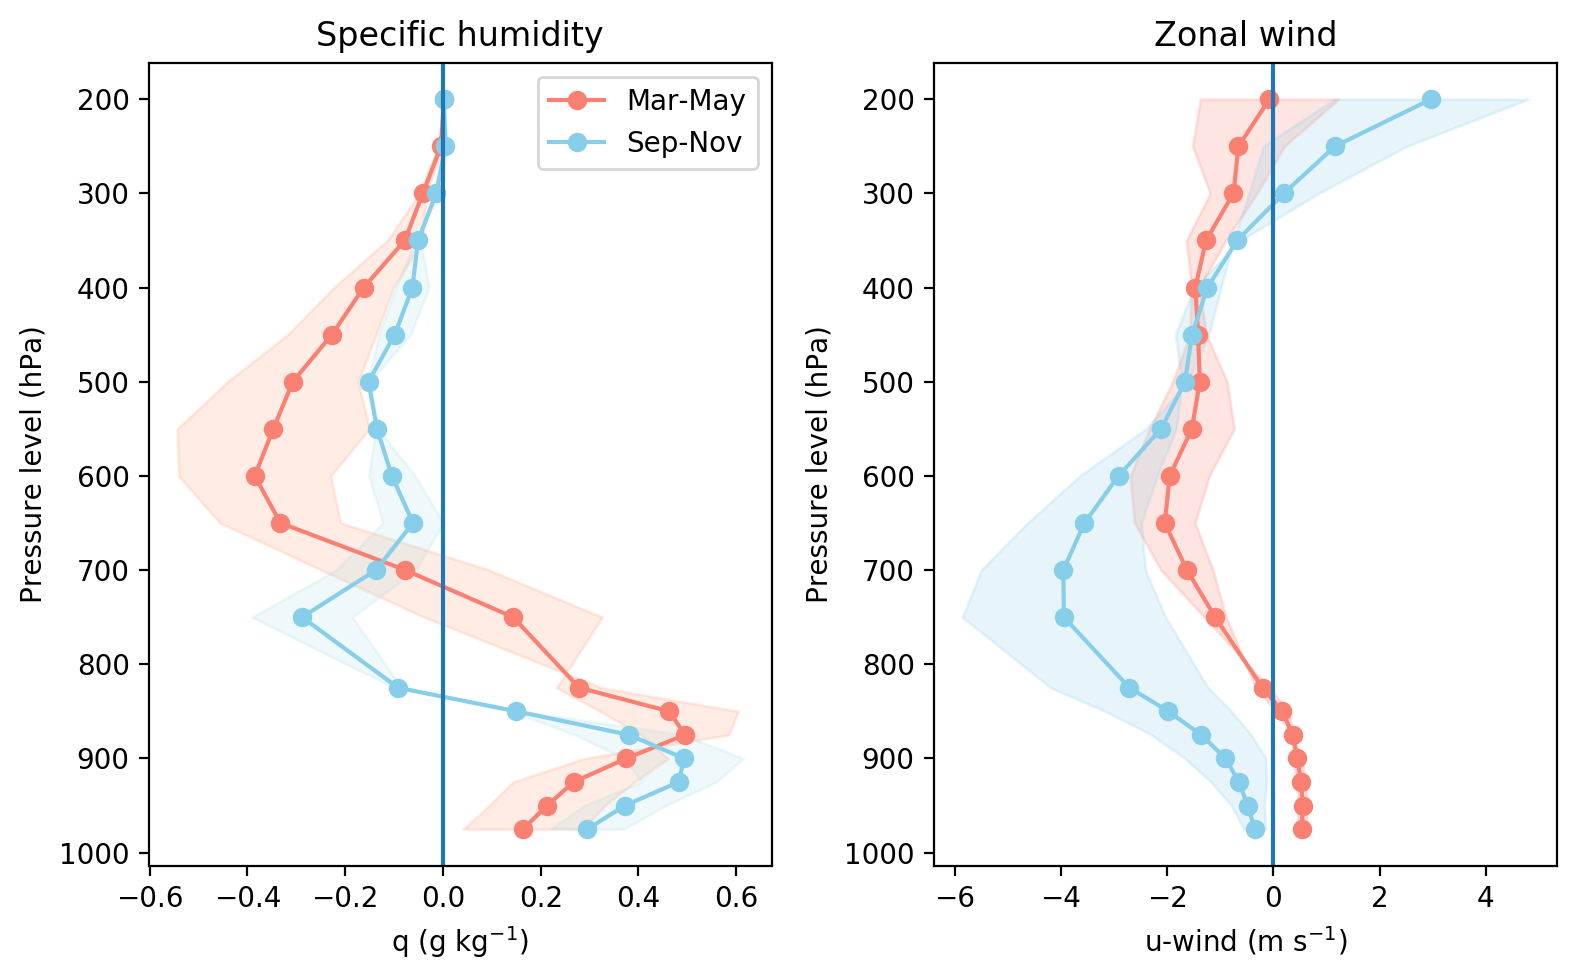

In [246]:
q_march =  np.array(mar_strong['q_col']).mean(axis=0)*1000 
q_oct =  np.array(oct_strong['q_col']).mean(axis=0)*1000 
f = plt.figure(figsize=(8,5), dpi=200)


q_march = np.array(mar_strong['q_col']).mean(axis=0)*1000 - np.array(mar_weak['q_col']).mean(axis=0)*1000 
q_oct = np.array(oct_strong['q_col']).mean(axis=0)*1000 - np.array(oct_weak['q_col']).mean(axis=0)*1000 

q_march_std = np.array(mar_strong['q_col']).std(axis=0)*1000 - np.array(mar_weak['q_col']).std(axis=0)*1000 
q_oct_std = np.array(oct_strong['q_col']).std(axis=0)*1000 - np.array(oct_weak['q_col']).std(axis=0)*1000 

f.add_subplot(121)
plt.plot(q_march,level,'-o', label='Mar-May', color='salmon')
# plt.plot(q_march_25, era_pl.level.values,'r.', label='March')
# plt.plot(q_march_25, era_pl.level.values,'r.', label='March')
plt.fill_betweenx(level, q_march+q_march_std, x2=q_march-q_march_std, color='lightsalmon', alpha=0.2)
plt.plot(q_oct,level,'-o', label='Sep-Nov', color='skyblue')
plt.fill_betweenx(level, q_oct+q_oct_std, x2=q_oct-q_oct_std, alpha=0.2, color='powderblue')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.ylabel('Pressure level (hPa)')
plt.xlabel('q (g kg$^{-1})$')
plt.title('Specific humidity')
plt.legend()

q_march = np.array(mar_strong['u_col']).mean(axis=0) - np.array(mar_weak['u_col']).mean(axis=0)
q_oct = np.array(oct_strong['u_col']).mean(axis=0) - np.array(oct_weak['u_col']).mean(axis=0)

q_march_std = np.array(mar_strong['u_col']).std(axis=0) - np.array(mar_weak['u_col']).std(axis=0) 
q_oct_std = np.array(oct_strong['u_col']).std(axis=0) - np.array(oct_weak['u_col']).std(axis=0)

f.add_subplot(122)
plt.plot(q_march, level,'o-', label='Mar-May', color='salmon')
plt.plot(q_oct, level,'o-', label='Sep-Nov', color='skyblue')
plt.fill_betweenx(level, q_march+q_march_std, x2=q_march-q_march_std, alpha=0.2, color='salmon')

plt.fill_betweenx(level, q_oct+q_oct_std, x2=q_oct-q_oct_std, color='skyblue', alpha=0.2)
plt.axvline(x=0)
plt.ylabel('Pressure level (hPa)')
plt.xlabel('u-wind (m s$^{-1})$')
plt.gca().invert_yaxis()
plt.title('Zonal wind')

plt.tight_layout()
#plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/uRHq_profiles_strongWeak_small.png')

Text(0,4,'c)')

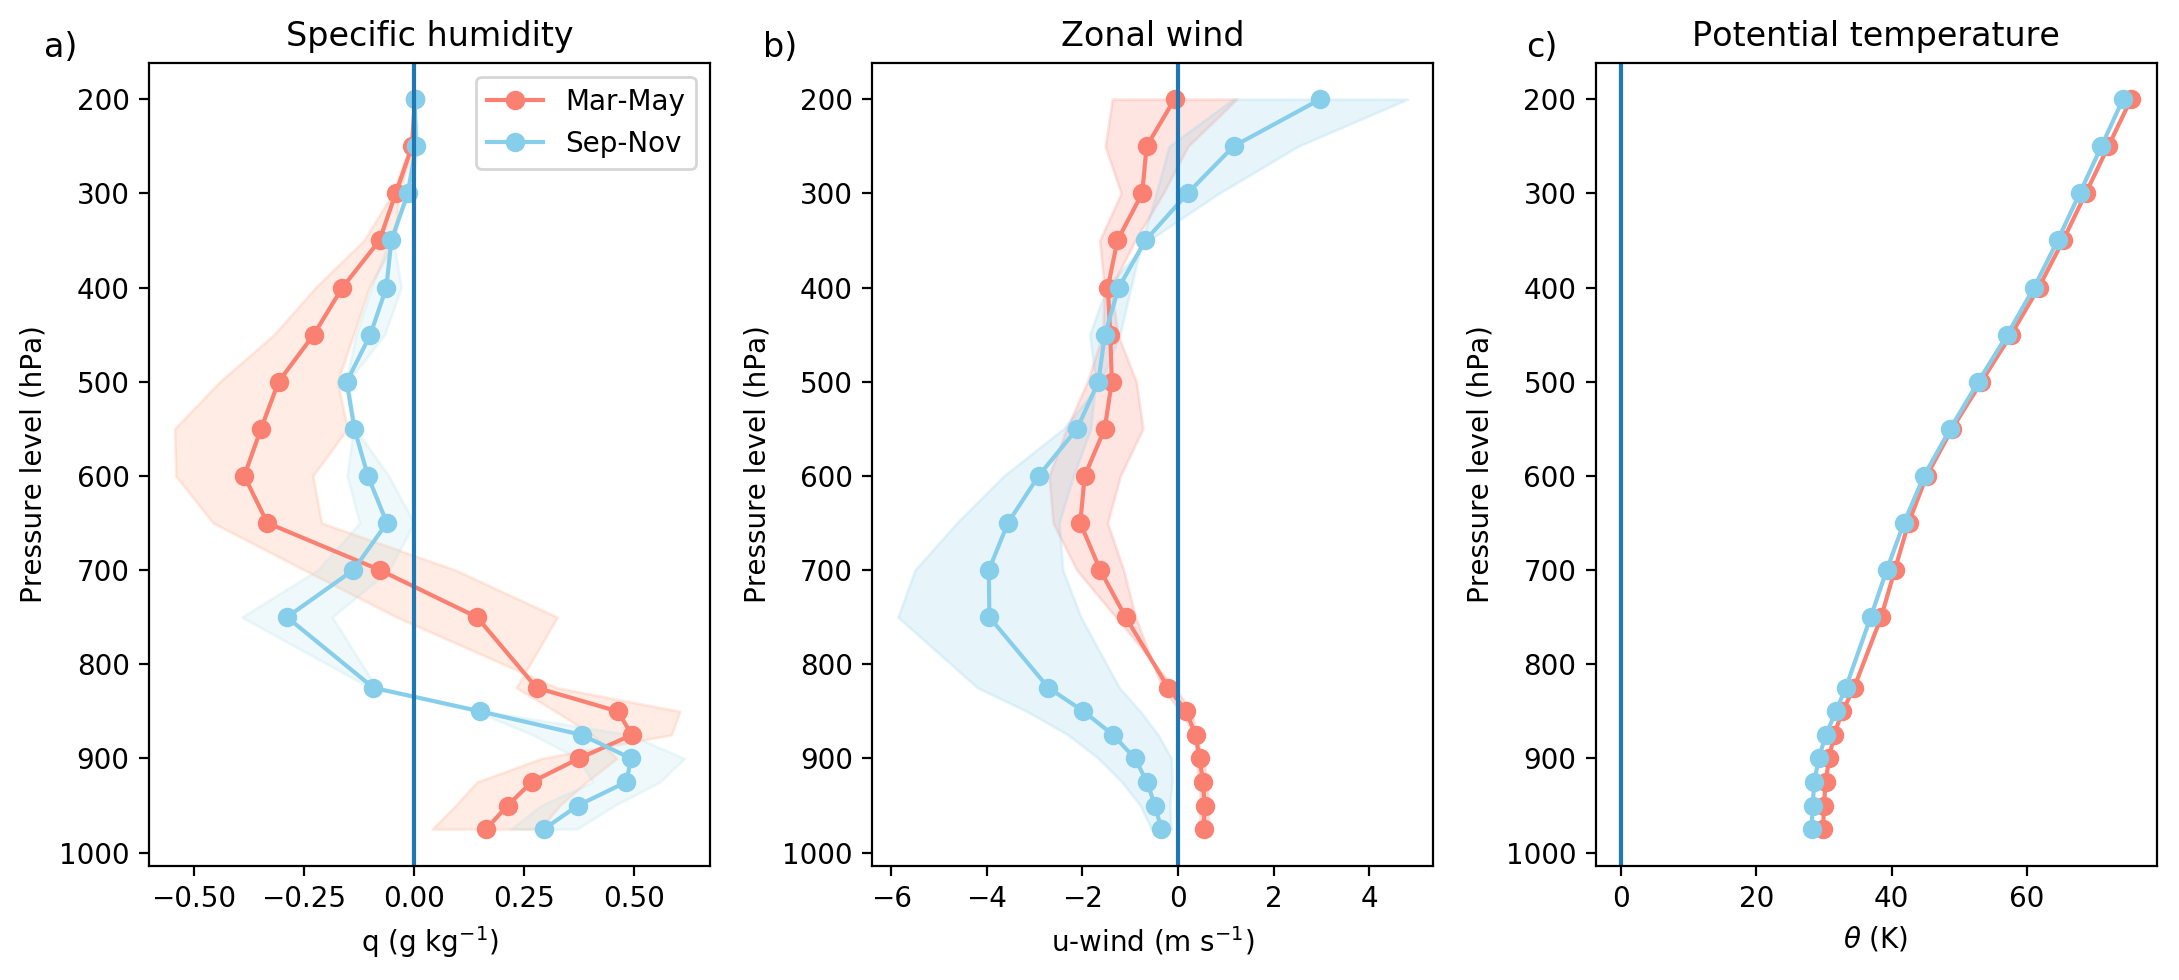

In [251]:
q_march =  np.array(mar_strong['q_col']).mean(axis=0)*1000 
q_oct =  np.array(oct_strong['q_col']).mean(axis=0)*1000 
f = plt.figure(figsize=(11,5), dpi=200)


q_march = np.array(mar_strong['q_col']).mean(axis=0)*1000 - np.array(mar_weak['q_col']).mean(axis=0)*1000 
q_oct = np.array(oct_strong['q_col']).mean(axis=0)*1000 - np.array(oct_weak['q_col']).mean(axis=0)*1000 

q_march_std = np.array(mar_strong['q_col']).std(axis=0)*1000 - np.array(mar_weak['q_col']).std(axis=0)*1000 
q_oct_std = np.array(oct_strong['q_col']).std(axis=0)*1000 - np.array(oct_weak['q_col']).std(axis=0)*1000 

f.add_subplot(131)
plt.plot(q_march,level,'-o', label='Mar-May', color='salmon')
# plt.plot(q_march_25, era_pl.level.values,'r.', label='March')
# plt.plot(q_march_25, era_pl.level.values,'r.', label='March')
plt.fill_betweenx(level, q_march+q_march_std, x2=q_march-q_march_std, color='lightsalmon', alpha=0.2)
plt.plot(q_oct,level,'-o', label='Sep-Nov', color='skyblue')
plt.fill_betweenx(level, q_oct+q_oct_std, x2=q_oct-q_oct_std, alpha=0.2, color='powderblue')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.ylabel('Pressure level (hPa)')
plt.xlabel('q (g kg$^{-1})$')
plt.title('Specific humidity')
plt.legend()

q_march = np.array(mar_strong['u_col']).mean(axis=0) - np.array(mar_weak['u_col']).mean(axis=0)
q_oct = np.array(oct_strong['u_col']).mean(axis=0) - np.array(oct_weak['u_col']).mean(axis=0)

q_march_std = np.array(mar_strong['u_col']).std(axis=0) - np.array(mar_weak['u_col']).std(axis=0) 
q_oct_std = np.array(oct_strong['u_col']).std(axis=0) - np.array(oct_weak['u_col']).std(axis=0)

f.add_subplot(132)
plt.plot(q_march, level,'o-', label='Mar-May', color='salmon')
plt.plot(q_oct, level,'o-', label='Sep-Nov', color='skyblue')
plt.fill_betweenx(level, q_march+q_march_std, x2=q_march-q_march_std, alpha=0.2, color='salmon')

plt.fill_betweenx(level, q_oct+q_oct_std, x2=q_oct-q_oct_std, color='skyblue', alpha=0.2)
plt.axvline(x=0)
plt.ylabel('Pressure level (hPa)')
plt.xlabel('u-wind (m s$^{-1})$')
plt.gca().invert_yaxis()
plt.title('Zonal wind')

v = 'theta'
q_march = np.array(mar_strong[v]).mean(axis=0) #- np.array(mar_weak[v]).mean(axis=0)
q_oct = np.array(oct_strong[v]).mean(axis=0) #- np.array(oct_weak[v]).mean(axis=0)

q_march_std = np.array(mar_strong[v]).std(axis=0) - np.array(mar_weak[v]).std(axis=0) 
q_oct_std = np.array(oct_strong[v]).std(axis=0) - np.array(oct_weak[v]).std(axis=0)

f.add_subplot(133)
plt.plot(q_march, level,'o-', label='Mar-May', color='salmon')
plt.plot(q_oct, level,'o-', label='Sep-Nov', color='skyblue')
#plt.fill_betweenx(level, q_march+q_march_std, x2=q_march-q_march_std, alpha=0.2, color='salmon')

#plt.fill_betweenx(level, q_oct+q_oct_std, x2=q_oct-q_oct_std, color='skyblue', alpha=0.2)
plt.axvline(x=0)
plt.ylabel('Pressure level (hPa)')
plt.xlabel(r'$\theta$ (K)')
plt.gca().invert_yaxis()
plt.title('Potential temperature')

plt.tight_layout()
plt.annotate('a)', xy=(0.02, 0.93), xytext=(0, 4), size=12, xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points')
plt.annotate('b)', xy=(0.35, 0.93), xytext=(0, 4), size=12, xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points')
plt.annotate('c)', xy=(0.7, 0.93), xytext=(0, 4), size=12, xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points')

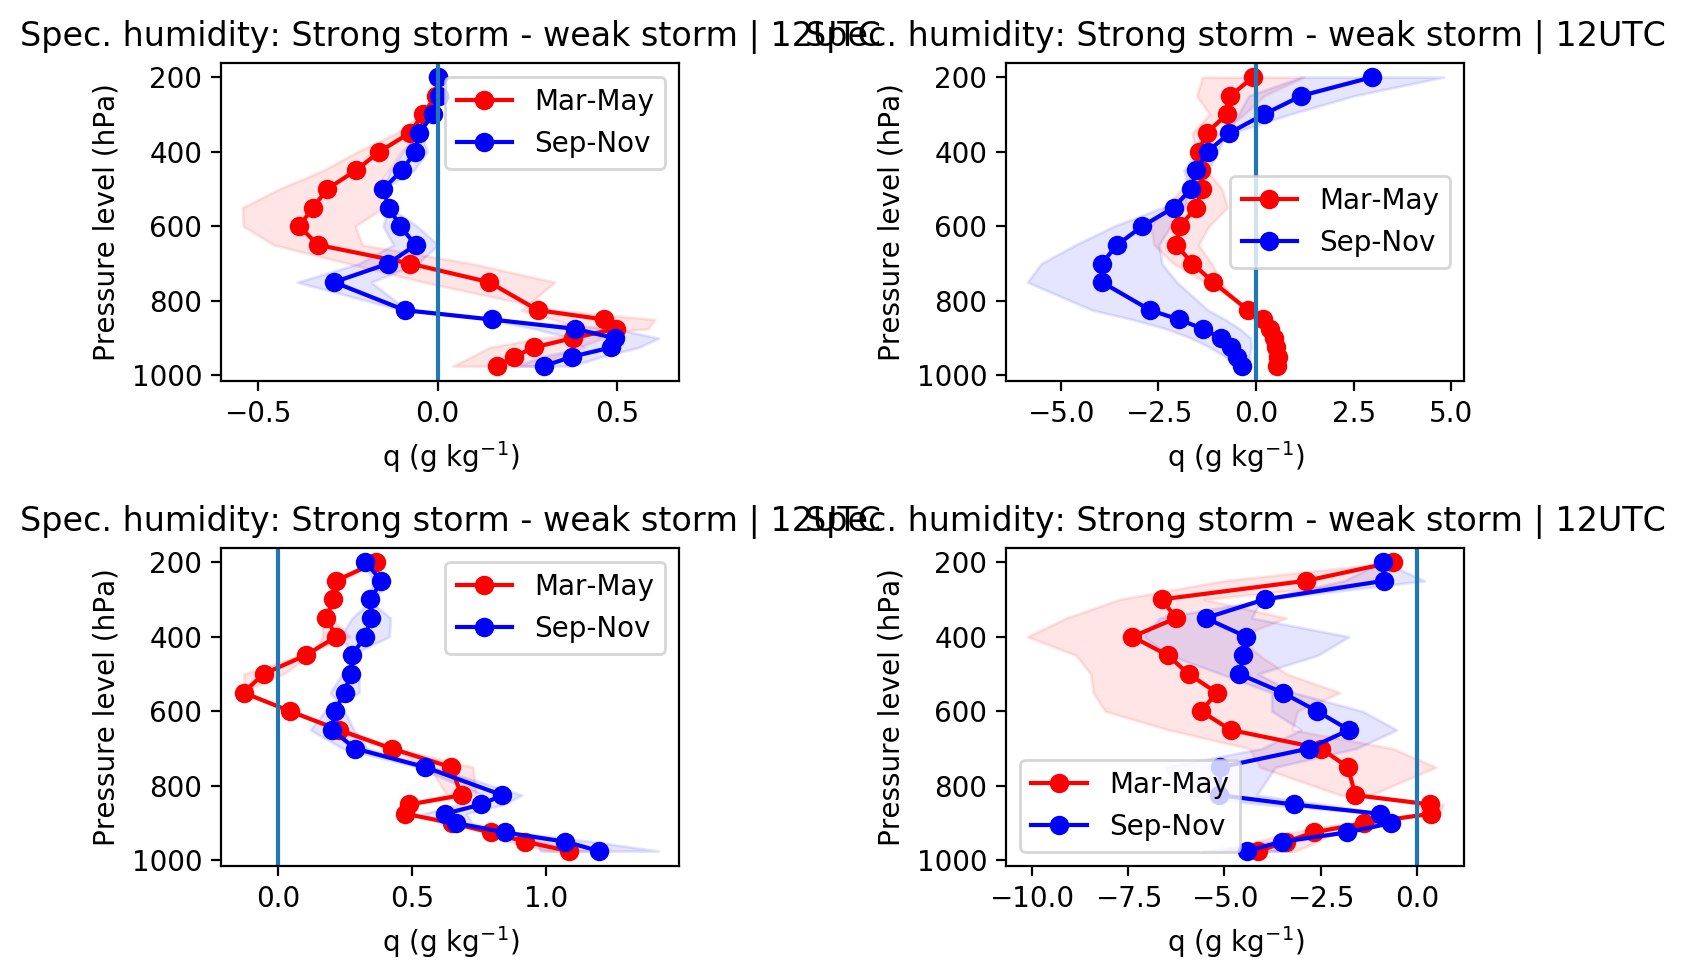

In [248]:
varss = [('q_col', 1000, ''), ('u_col', 1), ('t_col',1), ('r_col', 1)]

f = plt.figure(figsize=(8,5), dpi=200)

for ids, v in enumerate(varss):
    ax = f.add_subplot(2,2,ids+1)

    q_march = np.array(mar_strong[v[0]]).mean(axis=0)*v[1] - np.array(mar_weak[v[0]]).mean(axis=0)*v[1]
    q_oct = np.array(oct_strong[v[0]]).mean(axis=0)*v[1] - np.array(oct_weak[v[0]]).mean(axis=0)*v[1]

    q_march_std = np.array(mar_strong[v[0]]).std(axis=0)*v[1] - np.array(mar_weak[v[0]]).std(axis=0)*v[1] 
    q_oct_std = np.array(oct_strong[v[0]]).std(axis=0)*v[1] - np.array(oct_weak[v[0]]).std(axis=0)*v[1] 

    plt.plot(q_march, era_pl.level.values,'r-o', label='Mar-May')

    plt.fill_betweenx(era_pl.level.values, q_march+q_march_std, x2=q_march-q_march_std, color='r', alpha=0.1)
    plt.plot(q_oct, era_pl.level.values,'b-o', label='Sep-Nov')
    plt.fill_betweenx(era_pl.level.values, q_oct+q_oct_std, x2=q_oct-q_oct_std, color='b', alpha=0.1)
    plt.axvline(x=0)
    plt.gca().invert_yaxis()
    plt.ylabel('Pressure level (hPa)')
    plt.xlabel('q (g kg$^{-1})$')
    plt.title('Spec. humidity: Strong storm - weak storm | 12UTC')
    plt.legend()


plt.tight_layout()
#plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/uRHq_profiles_strongWeak_small.png')

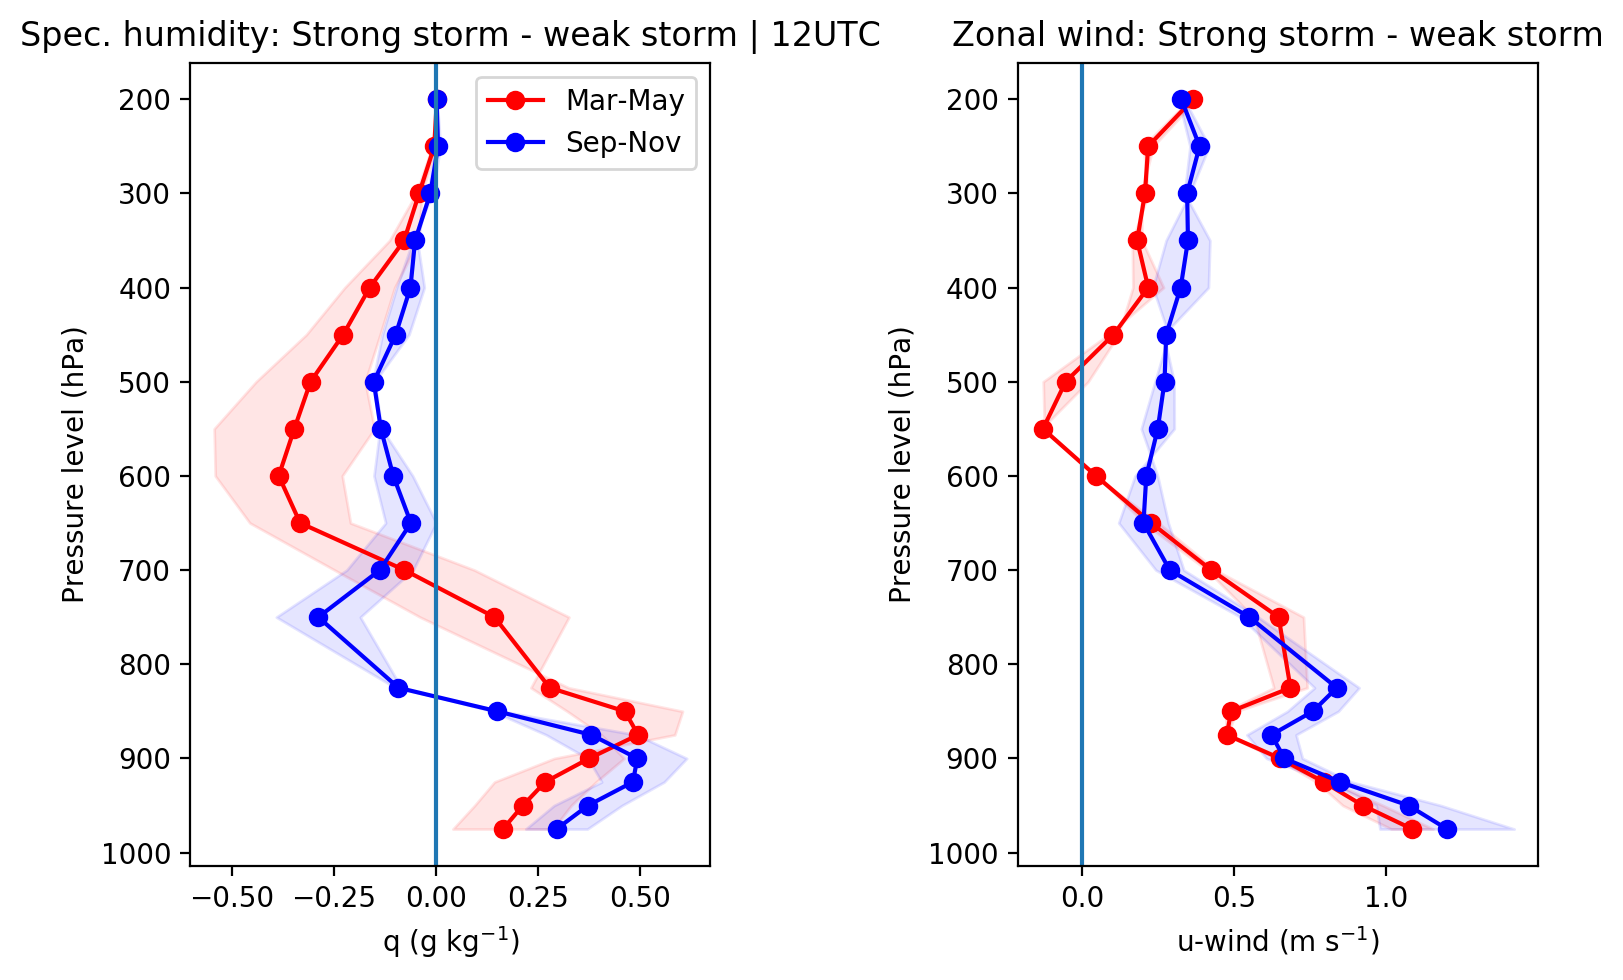

In [249]:
q_march =  np.array(mar_strong['q_col']).mean(axis=0)*1000 
q_oct =  np.array(oct_strong['q_col']).mean(axis=0)*1000 
f = plt.figure(figsize=(8,5), dpi=200)


q_march = np.array(mar_strong['q_col']).mean(axis=0)*1000 - np.array(mar_weak['q_col']).mean(axis=0)*1000 
q_oct = np.array(oct_strong['q_col']).mean(axis=0)*1000 - np.array(oct_weak['q_col']).mean(axis=0)*1000 
# q_march_25 = (np.percentile(np.array(mar_strong['q_col']), 25, axis=0) - \
#             np.percentile(np.array(mar_weak['q_col']), 25, axis=0))*1000

# q_march_75 = (np.percentile(np.array(mar_strong['q_col']), 75, axis=0) - \
#             np.percentile(np.array(mar_weak['q_col']), 75, axis=0))*1000

q_march_std = np.array(mar_strong['q_col']).std(axis=0)*1000 - np.array(mar_weak['q_col']).std(axis=0)*1000 
q_oct_std = np.array(oct_strong['q_col']).std(axis=0)*1000 - np.array(oct_weak['q_col']).std(axis=0)*1000 

f.add_subplot(121)
plt.plot(q_march, era_pl.level.values,'r-o', label='Mar-May')
# plt.plot(q_march_25, era_pl.level.values,'r.', label='March')
# plt.plot(q_march_25, era_pl.level.values,'r.', label='March')
plt.fill_betweenx(era_pl.level.values, q_march+q_march_std, x2=q_march-q_march_std, color='r', alpha=0.1)
plt.plot(q_oct, era_pl.level.values,'b-o', label='Sep-Nov')
plt.fill_betweenx(era_pl.level.values, q_oct+q_oct_std, x2=q_oct-q_oct_std, color='b', alpha=0.1)
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.ylabel('Pressure level (hPa)')
plt.xlabel('q (g kg$^{-1})$')
plt.title('Spec. humidity: Strong storm - weak storm | 12UTC')
plt.legend()

q_march = np.array(mar_strong['t_col']).mean(axis=0) - np.array(mar_weak['t_col']).mean(axis=0)
q_oct = np.array(oct_strong['t_col']).mean(axis=0) - np.array(oct_weak['t_col']).mean(axis=0)

q_march_std = np.array(mar_strong['t_col']).std(axis=0) - np.array(mar_weak['t_col']).std(axis=0) 
q_oct_std = np.array(oct_strong['t_col']).std(axis=0) - np.array(oct_weak['t_col']).std(axis=0)

f.add_subplot(122)
plt.plot(q_march, era_pl.level.values,'ro-', label='Mar-May')
plt.plot(q_oct, era_pl.level.values,'bo-', label='Sep-Nov')
plt.fill_betweenx(era_pl.level.values, q_march+q_march_std, x2=q_march-q_march_std, color='r', alpha=0.1)

plt.fill_betweenx(era_pl.level.values, q_oct+q_oct_std, x2=q_oct-q_oct_std, color='b', alpha=0.1)
plt.axvline(x=0)
plt.ylabel('Pressure level (hPa)')
plt.xlabel('u-wind (m s$^{-1})$')
plt.gca().invert_yaxis()
plt.title('Zonal wind: Strong storm - weak storm')

plt.tight_layout()
#plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/uRHq_profiles_strongWeak_small.png')

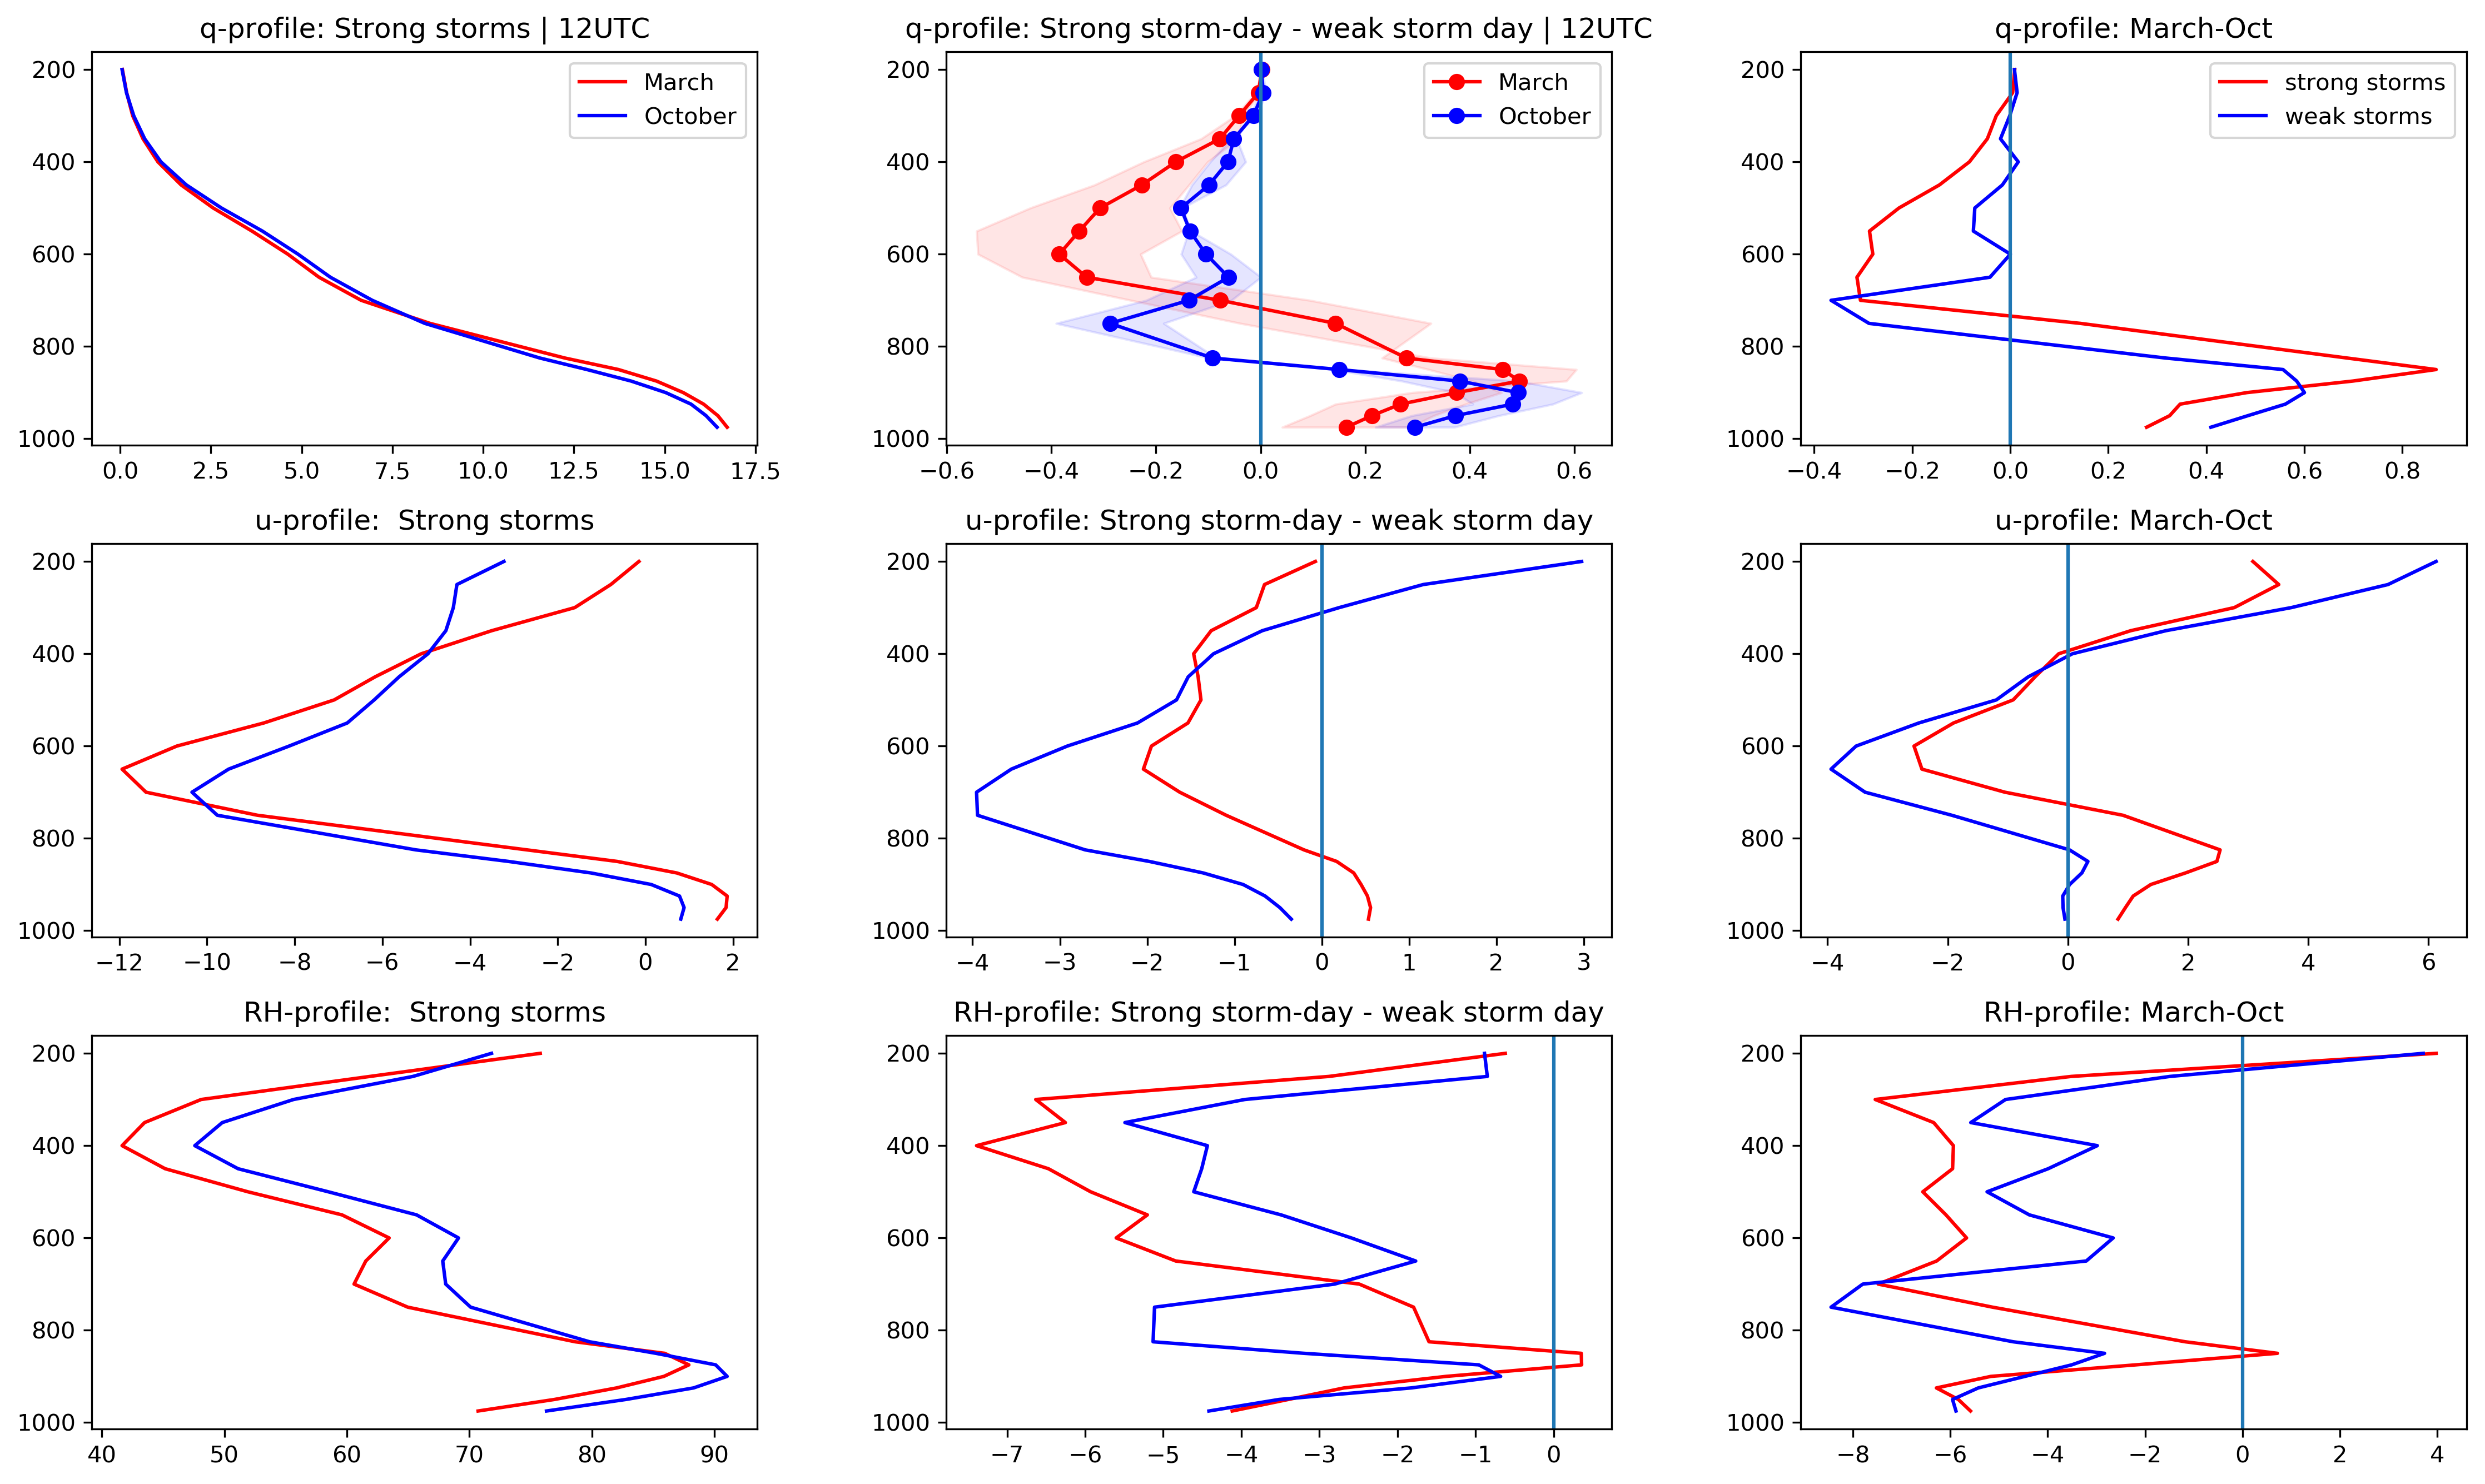

In [250]:
q_march =  np.array(mar_strong['q_col']).mean(axis=0)*1000 
q_oct =  np.array(oct_strong['q_col']).mean(axis=0)*1000 
f = plt.figure(figsize=(15,9), dpi=300)
f.add_subplot(331)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: Strong storms | 12UTC')
plt.legend()

q_march =  np.array(mar_strong['u_col']).mean(axis=0)
q_oct =  np.array(oct_strong['u_col']).mean(axis=0)
f.add_subplot(334)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile:  Strong storms')

q_march = np.array(mar_strong['q_col']).mean(axis=0)*1000 - np.array(mar_weak['q_col']).mean(axis=0)*1000 
q_oct = np.array(oct_strong['q_col']).mean(axis=0)*1000 - np.array(oct_weak['q_col']).mean(axis=0)*1000 
# q_march_25 = (np.percentile(np.array(mar_strong['q_col']), 25, axis=0) - \
#             np.percentile(np.array(mar_weak['q_col']), 25, axis=0))*1000

# q_march_75 = (np.percentile(np.array(mar_strong['q_col']), 75, axis=0) - \
#             np.percentile(np.array(mar_weak['q_col']), 75, axis=0))*1000

q_march_std = np.array(mar_strong['q_col']).std(axis=0)*1000 - np.array(mar_weak['q_col']).std(axis=0)*1000 
q_oct_std = np.array(oct_strong['q_col']).std(axis=0)*1000 - np.array(oct_weak['q_col']).std(axis=0)*1000 

f.add_subplot(332)
plt.plot(q_march, era_pl.level.values,'r-o', label='March')
# plt.plot(q_march_25, era_pl.level.values,'r.', label='March')
# plt.plot(q_march_25, era_pl.level.values,'r.', label='March')
plt.fill_betweenx(era_pl.level.values, q_march+q_march_std, x2=q_march-q_march_std, color='r', alpha=0.1)
plt.plot(q_oct, era_pl.level.values,'b-o', label='October')
plt.fill_betweenx(era_pl.level.values, q_oct+q_oct_std, x2=q_oct-q_oct_std, color='b', alpha=0.1)
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: Strong storm-day - weak storm day | 12UTC')
plt.legend()

q_march = np.array(mar_strong['u_col']).mean(axis=0) - np.array(mar_weak['u_col']).mean(axis=0)
q_oct = np.array(oct_strong['u_col']).mean(axis=0) - np.array(oct_weak['u_col']).mean(axis=0)
f.add_subplot(335)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile: Strong storm-day - weak storm day')


q_march = np.array(mar_strong['q_col']).mean(axis=0)*1000  - np.array(oct_strong['q_col']).mean(axis=0)*1000 
q_oct = np.array(mar_weak['q_col']).mean(axis=0)*1000 - np.array(oct_weak['q_col']).mean(axis=0)*1000
f.add_subplot(333)
plt.plot(q_march, era_pl.level.values,'r', label='strong storms')
plt.plot(q_oct, era_pl.level.values,'b', label='weak storms')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: March-Oct')
plt.legend()

q_march = np.array(mar_strong['u_col']).mean(axis=0) - np.array(oct_strong['u_col']).mean(axis=0)
q_oct = np.array(mar_weak['u_col']).mean(axis=0) - np.array(oct_weak['u_col']).mean(axis=0)
f.add_subplot(336)
plt.plot(q_march, era_pl.level.values,'r', label='strong storms')
plt.plot(q_oct, era_pl.level.values,'b', label='weak storms')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile: March-Oct')

sstr = 'r_col'

q_march =  np.array(mar_strong[sstr]).mean(axis=0)
q_oct =  np.array(oct_strong[sstr]).mean(axis=0)
f.add_subplot(337)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile:  Strong storms')

q_march = np.array(mar_strong[sstr]).mean(axis=0) - np.array(mar_weak[sstr]).mean(axis=0)
q_oct = np.array(oct_strong[sstr]).mean(axis=0) - np.array(oct_weak[sstr]).mean(axis=0)
f.add_subplot(338)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile: Strong storm-day - weak storm day')

q_march = np.array(mar_strong[sstr]).mean(axis=0) - np.array(oct_strong[sstr]).mean(axis=0)
q_oct = np.array(mar_weak[sstr]).mean(axis=0) - np.array(oct_weak[sstr]).mean(axis=0)
f.add_subplot(339)
plt.plot(q_march, era_pl.level.values,'r', label='strong storms')
plt.plot(q_oct, era_pl.level.values,'b', label='weak storms')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile: March-Oct')

plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/uRHq_profiles_strongWeak.png')

In [ ]:
plt.figure(figsize=(9,5))
plt.hist(np.array(era_march['area']), bins=30)
plt.hist(np.array(era_oct['area']), bins=30)

In [ ]:
## a clean way of plotting - use matplotlib functions directly:

def draw_cross(data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, twinx=None, **kwargs):
    f=plt.figure(figsize=(15,7))  # this opens a plot window
    ax = f.add_subplot(111)  # this opens a new plot axis
    mapp = ax.contourf(lon, lat, data, **kwargs, extend='both')  # this is the actual plot
    plt.gca().invert_yaxis()
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
        
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        plt.clabel(cs, inline=1, fontsize=10)
        
    if twinx is not None:
        ax1 = ax.twinx()
        ax1.plot(twinx['x'], twinx['y'], twinx['color'] )
        ax1.set_ylabel(twinx['ylabel'])
        ax1.set_ylim(twinx['ylim'][0], twinx['ylim'][1])
    
    plt.title(title)
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.show() 

In [ ]:
era_pl['ymonth'] = ('time', [str(m)+'-'+str(h) for (m,h) in zip(era_pl['time.month'].values,era_pl['time.hour'].values)])
grouped='ymonth'
era_pl_cross =  era_pl.groupby(grouped).mean(dim='time')

In [ ]:
era_pl_cross.ymonth

In [ ]:
cross_march = era_pl_cross.sel(ymonth='3-12')
cross_oct = era_pl_cross.sel(ymonth='10-12')

In [ ]:
era_pl_cross

In [ ]:
cross_march['t'].values-273.15

In [ ]:
ccross_march = cross_march.sel(longitude=slice(-10,10)).mean('longitude')
ccross_oct = cross_oct.sel(longitude=slice(-10,10)).mean('longitude')

In [ ]:
cross_march

In [ ]:
# "current zonal wind" wind vectors
uano = ccross_march['u']
wano = ccross_march['w']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
st=3
sarrow = 1
xquiv = ccross_march.latitude[sarrow::st]
yquiv = ccross_march.level

uu = (uano)[::, sarrow::st]  
ww = (wano)[::, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 80}

In [ ]:
# temperature and moisture check
data = (ccross_march['u'])
contour = {'data' : data, 'x' : ccross_march.latitude, 'y' : ccross_march.level, 'levels' : np.arange(-10,10,2), 'cmap' : 'PuOr'}
draw_cross((ccross_march['t']-ccross_oct['t']), ccross_march.latitude, ccross_march.level, cmap='RdBu_r', 
           levels=np.linspace(-2,2,10), quiver=qin, contour=contour, title='Current-past: shading - T, contours - q, vectors: zonal wind')

In [ ]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map(data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):
    f=plt.figure(figsize=(15,7))  # this opens a plot window
    ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.show()   

In [ ]:
(cross_march)['u']

In [ ]:
lon=cross_march.longitude
lat=cross_march.latitude
map_cross_march = cross_march.sel(level=925)
map_cross_oct = cross_oct.sel(level=925)
data=map_cross_march['t']-map_cross_oct['t']
data2=map_cross_march['q']-map_cross_oct['q']
title=''

contour = {'data' : data2*1000, 'x' : lon, 'y' : lat, 'levels' : np.arange(-3,3,0.4), 'cmap' : 'PuOr'}

# preparation of wind vector data in plot
st=4
sarrow = 2
xquiv = map_cross_march.longitude[sarrow::st]
yquiv = map_cross_march.latitude[sarrow::st]

uu = (map_cross_march['u'])[sarrow::st, sarrow::st]
vv = (map_cross_march['v'])[sarrow::st, sarrow::st]


qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : 70}

draw_map(data, lon, lat, title=title, levels=np.linspace(-7,7,8), extend='both', quiver=qin, cmap='RdBu_r', contour=contour, cbar_label= 'mm day$^{-1}$')


In [ ]:
def linear_trend_lingress_2d(x, nb_missing=None, sig=None, method=None):
    
    
    # stack lat and lon into a single dimension called allpoints
    datastacked = x.stack(allpoints=['latitude', 'level'])

    # apply the function over allpoints to calculate the trend at each point
    print('Entering trend calc')

    alpha = 0.05
    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='mk':
        dtrend = datastacked.groupby('allpoints').apply(uda.linear_trend_mk, alpha=alpha, eps=0.0001,nb_missing=10)
        dtrend = dtrend.unstack('allpoints')
        if sig:
            (dtrend['slope'].values)[dtrend['ind'].values==0] = 0

    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='polyfit':
        dtrend = datastacked.groupby('allpoints').apply(uda.linear_trend_lingress,nb_missing=10)
        dtrend = dtrend.unstack('allpoints')

        if sig:
            (dtrend['slope'].values)[dtrend['pval'].values > alpha] = np.nan
            
    return dtrend['slope']

In [ ]:
era_srfc = xr.open_dataset(cnst.ERA_MONTHLY_SRFC)
era_pl = xr.open_dataset(cnst.ERA_MONTHLY_PL)
ccover = xr.open_dataset(cnst.GRIDSAT + 'aggs/gridsat_WA_-70_monthly_count.nc')
era_srfc = uda.flip_lat(era_srfc)
era_pl = uda.flip_lat(era_pl)
era_trend = era_pl.sel(longitude=slice(-10,10)).squeeze().mean('longitude')

In [ ]:
def trends_month(var):
    
    utrend = era_trend[var][(era_trend['time.year']>1982)].groupby('time.month').apply(linear_trend_lingress_2d,nb_missing=10, method='mk')*10
    
    return utrend

In [ ]:
utrend = trends_month('t')

In [ ]:
ccross_march['t'].values = u_met.theta(ccross_march.level.values, ccross_march['t'].values-273.15)

In [ ]:
ccross_march['t'].values

In [ ]:
# temperature and moisture check
data = (ccross_march['t'])
contour = {'data' : data, 'x' : ccross_march.latitude, 'y' : ccross_march.level, 'levels' : np.linspace(data.min(),data.max(),10), 'cmap' : 'PuOr'}
draw_cross(utrend.sel(month=3), utrend.latitude, utrend.level, cmap='RdBu_r', contour=contour,
           levels=np.linspace(-0.5,0.5,10), title='Current-past: shading - T, contours - q, vectors: zonal wind')